In [16]:
'''
Investigating various feature importance techniques to analyse prediction results of different ML methods
Feature importance techniques:
1) Impurity-based feature importance
2) Permutation feature importance
3) SHAP
'''

import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.preprocessing import MinMaxScaler, normalize
from pygam import GAM, s, f, LinearGAM
from sklearn.inspection import permutation_importance
import xgboost
import shap
import nbimporter
from Prediction import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data

In [4]:
# Set the working directory
os.chdir("N:/WG_ENRI/20_projects/Noise2NAKO/04_data/grid_prediction/3_output")

In [5]:
# Read training and test data
data_training = pd.read_csv('Prediction/Reduced_data_SSel/Reduced_data_SSel_minmax_scaled_Training_data.csv', sep=',')
data_test = pd.read_csv('Prediction/Reduced_data_SSel/Reduced_data_SSel_minmax_scaled_Test_data.csv', sep=',')

In [13]:
# distinguish between response and input variables and make training and test data 
# remove unnecessary features 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'

output_variable = 'cvd_mortality_17'
# 0_original_data
# 1_standard_scaled_data
# 2_minmax_scaled_data
output_path = 'CVD Mortality Rate 2017_allExposures_XY/Reduced_data_SSel/2_minmax_scaled_data'

# output_variable = 'ks_Mortality_17'
# output_path = 'Total Mortality Rate 2017 incl XY'

output_path = '../5_results/' + output_path + '/'
coord = True

y = data_training[output_variable]
if coord:
    X = data_training.drop([output_variable, 'id'], axis = 1)   
else:
    X = data_training.drop([output_variable, 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'], axis = 1)
    
pred_y = data_test[output_variable]
if coord:
    pred_X = data_test.drop([output_variable, 'id'], axis = 1)
else:
    pred_X = data_test.drop([output_variable, 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

features = X_train.columns

## Necessary Functions

In [9]:
def feature_imp_plot_bar(to_plot, methods, font_size, file_path):
    
    fig = plt.figure(figsize=(30,5))
    ax = fig.add_subplot(111)
    
    X_axis = np.arange(len(to_plot.columns))
    for i in range(len(methods)):
        ax.bar(X_axis + i * 0.1, to_plot.iloc[i], 0.1, label=methods[i])
        
    plt.xticks(X_axis, to_plot.columns, rotation='vertical', fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc='upper left', fontsize= font_size - 5)
    plt.ylabel('Feature Importance', fontsize = font_size + 5)
    plt.savefig(file_path)
    plt.show()

In [10]:
def feature_imp_plot_scatter(to_plot, methods, font_size, file_path):
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    
    X_axis = np.arange(len(to_plot.columns))
    for i in range(len(methods)):
        ax.scatter(to_plot.columns, to_plot.iloc[i], s = 100, label=methods[i])
        
    plt.xticks(X_axis, to_plot.columns, rotation='vertical', fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc='upper left', fontsize= font_size - 5)
    plt.ylabel('Feature Importance', fontsize = font_size + 5)
    plt.savefig(file_path)
    plt.show()

In [11]:
def plot_feature_importances(importances, method, file_path, approach):
        fig, ax = plt.subplots(figsize = (15,5))
        importances.plot.bar(ax=ax)
        ax.set_title('Feature importances using '+ approach +'_' + method)
        if approach == 'MDI':
            ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
        plt.savefig(file_path)
        plt.show()

In [42]:
def Build_fit_all_methods(methods, X_train, y_train):
    
    models = []
    for method in methods:
        # Build and fit the model with the proper data
        models.append(Build_fit_model(method, X_train, y_train))
    
    return models

In [43]:
# Build and train all the models for all specified methods and save them for the future

methods = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'RF','AdaB', 'XGBoost']
models = Build_fit_all_methods(methods, X_train, y_train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'learning_rate': [0.1,
                   0.2,
                   0.3,
                   0.4,
                   0.5,
                   0.6,
                   0.7,
                   0.7999999999999999,
                   0.8999999999999999,
                   0.9999999999999999,
                   1.0999999999999999,
                   1.2,
                   1.3,
                   1.4,
                   1.5,
                   1.5999999999999999,
                   1.7,
                   1.8,
                   1.9,
                   2.0],
 'loss': ['linear', 'square', 'exponential'],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000

# Impurity-based Feature Importance
When provided by the algorithms (e.g., Random Forest), we show them!

In [30]:
def Impurity_feature_importance(method, X_train, y_train, output_path):
    
    model = Build_fit_model(method, X_train, y_train)
    
    if method in ['RF' , 'XGBoost', 'AdaB']:
        importances = model.feature_importances_
    
    if method in ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic']:
        coef = model.coef_ - min(model.coef_)
        importances = coef/sum(coef)

    variable_importances = pd.Series(importances, index= X_train.columns)
    plot_feature_importances(variable_importances, method, output_path + method + '/' + method + '_MDI_feature_imp_plot', 'MDI')
    
    return importances

In [53]:
def Impurity_feature_importance_from_model(model, method, X_train, y_train, output_path):
    if method in ['RF' , 'XGBoost', 'AdaB']:
        importances = model.feature_importances_
    
    if method in ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic']:
        coef = model.coef_ - min(model.coef_)
        importances = coef/sum(coef)

    variable_importances = pd.Series(importances, index= X_train.columns)
    plot_feature_importances(variable_importances, method, output_path + method + '/' + method + '_MDI_feature_imp_plot', 'MDI')
    
    return importances

### Comparing feature importance of different methods

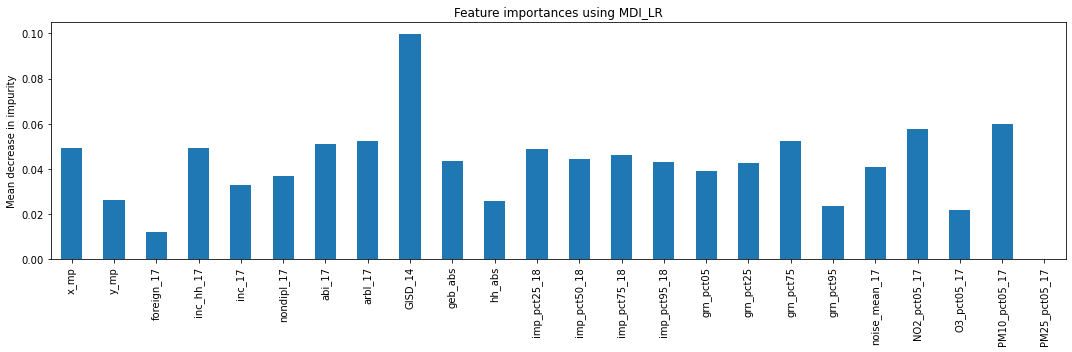

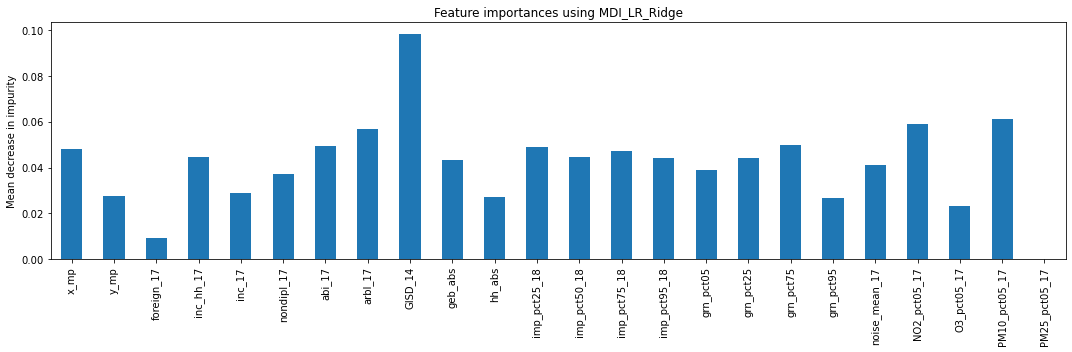

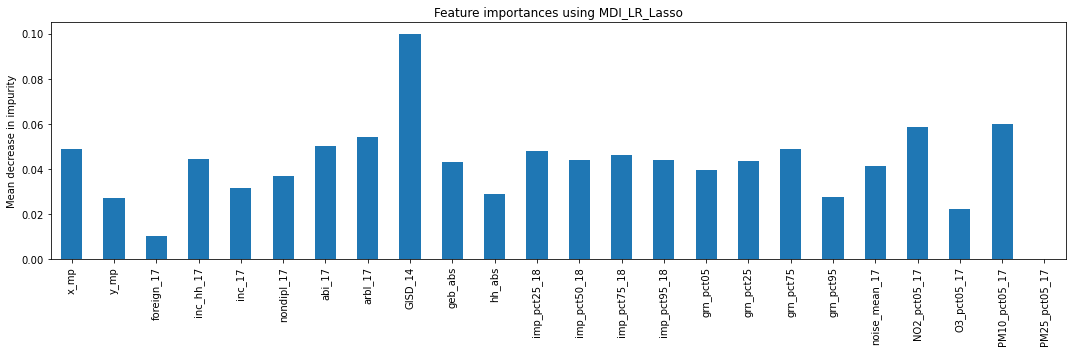

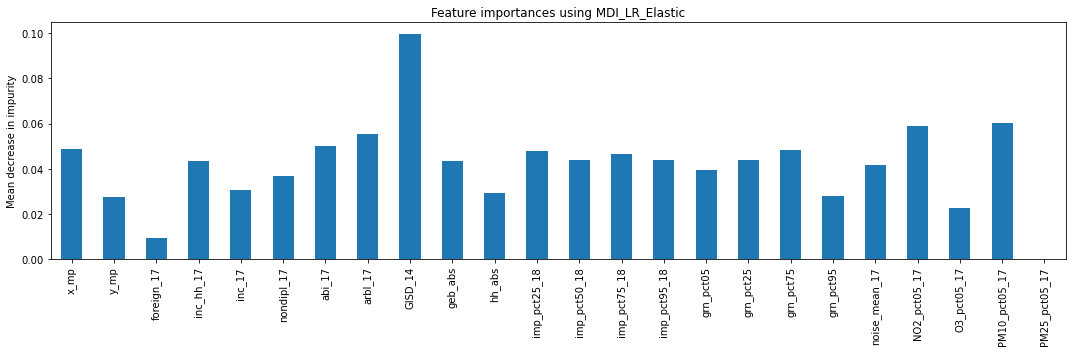

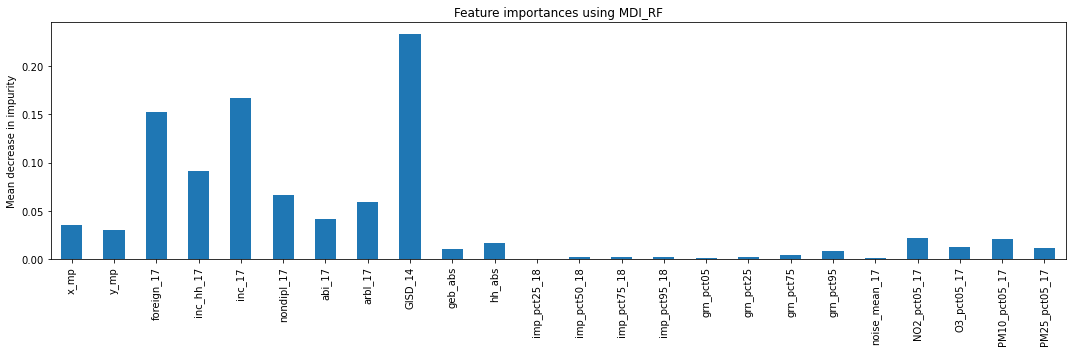

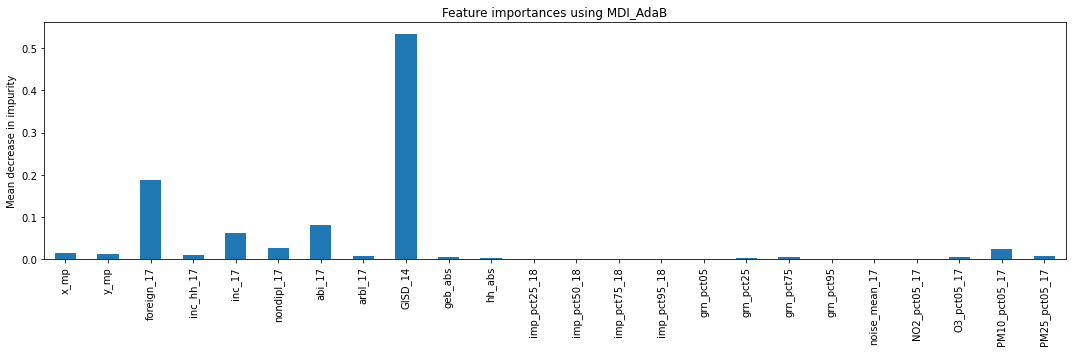

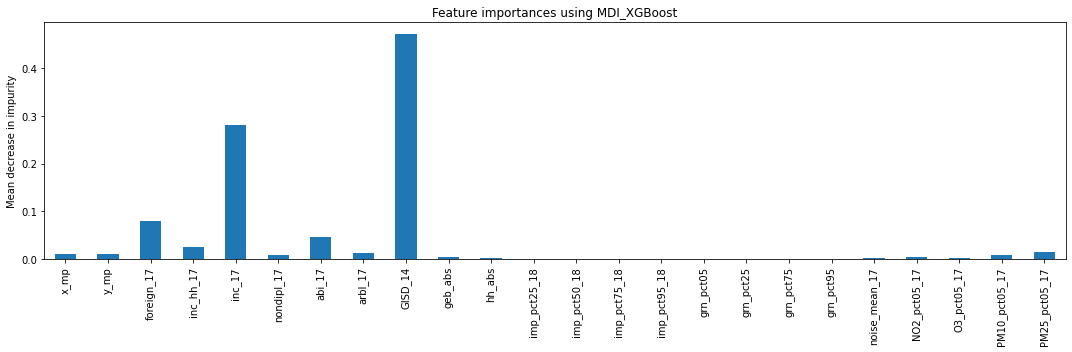

,x_mp,y_mp,foreign_17,inc_hh_17,inc_17,nondipl_17,abi_17,arbl_17,GISD_14,geb_abs,...,grn_pct05,grn_pct25,grn_pct75,grn_pct95,noise_mean_17,NO2_pct05_17,O3_pct05_17,PM10_pct05_17,PM25_pct05_17,Method
0,0.049270,0.026427,0.012187,0.049314,0.032806,0.036862,0.051116,0.052547,0.099851,0.043548,...,0.038932,0.042674,0.052472,0.023798,0.040718,0.057476,0.021970,0.059778,0.000000,LR
1,0.048159,0.027483,0.009080,0.044427,0.029033,0.037099,0.049544,0.056887,0.098347,0.043485,...,0.039100,0.044252,0.049943,0.026681,0.041131,0.058857,0.023338,0.061267,0.000000,LR_Ridge
2,0.048821,0.027251,0.010272,0.044391,0.031640,0.036907,0.050327,0.054413,0.099995,0.043310,...,0.039544,0.043403,0.048941,0.027526,0.041407,0.058446,0.022151,0.059907,0.000000,LR_Lasso
3,0.048579,0.027445,0.009550,0.043455,0.030819,0.036975,0.049970,0.055362,0.099747,0.043455,...,0.039573,0.043707,0.048401,0.028123,0.041514,0.058730,0.022461,0.060238,0.000000,LR_Elastic
4,0.035656,0.030621,0.152394,0.091801,0.167134,0.066332,0.041889,0.059701,0.233377,0.010337,...,0.001729,0.002245,0.004680,0.008681,0.001413,0.022478,0.012755,0.020989,0.012193,RF
5,0.015854,0.012062,0.188657,0.010217,0.063310,0.025897,0.080866,0.006962,0.534616,0.006477,...,0.001527,0.003048,0.004937,0.001074,0.000690,0.001625,0.005944,0.024283,0.008587,AdaB
6,0.010417,0.012030,0.079543,0.024850,0.281885,0.008079,0.046547,0.013271,0.471959,0.005416,...,0.000647,0.000941,0.000954,0.001227,0.002099,0.005477,0.003187,0.009442,0.016057,XGBoost


In [50]:
# Use already built models

feature_imp = pd.DataFrame(columns = features)

methods = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'RF','AdaB', 'XGBoost']
for i in range(len(methods)):
    toAppend_imp = Impurity_feature_importance_from_model(models[i], methods[i], X_train, y_train, output_path)
    feature_imp = feature_imp.append(pd.DataFrame(toAppend_imp.reshape(1,-1), columns= features), ignore_index=True)

feature_imp['Method'] = methods
feature_imp

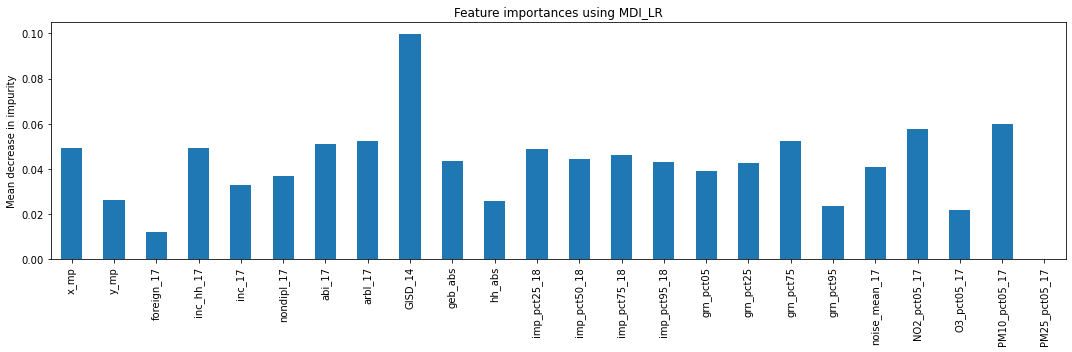

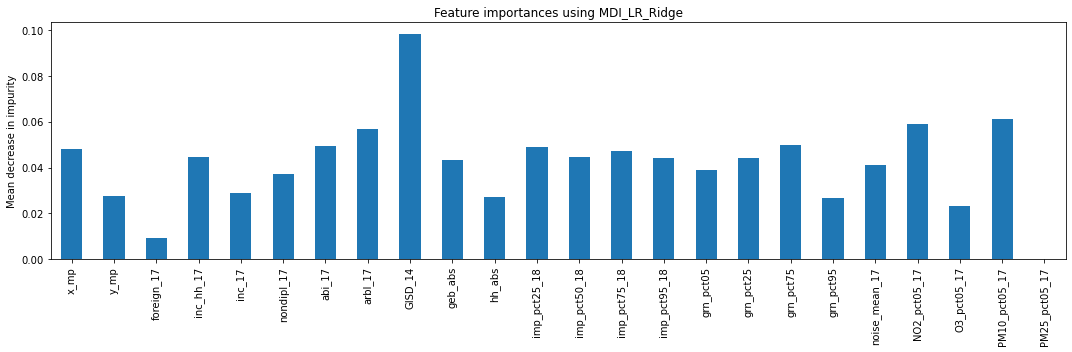

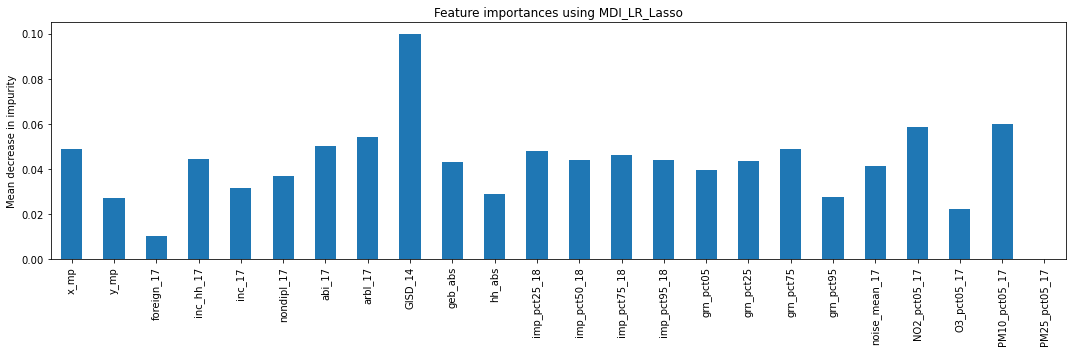

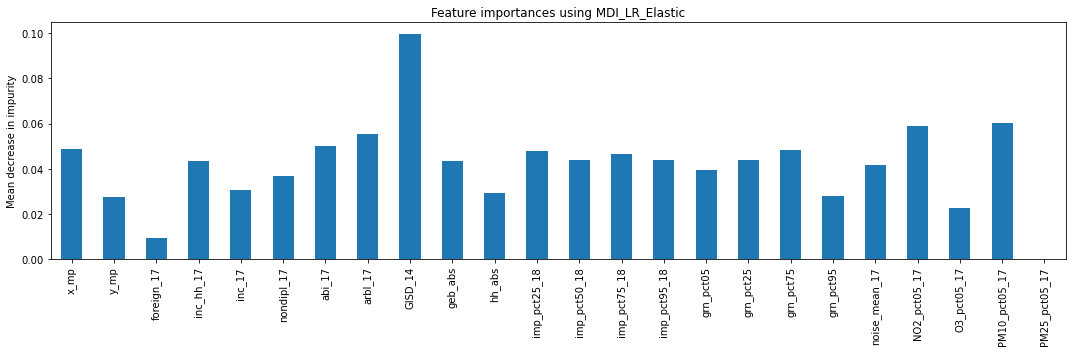

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


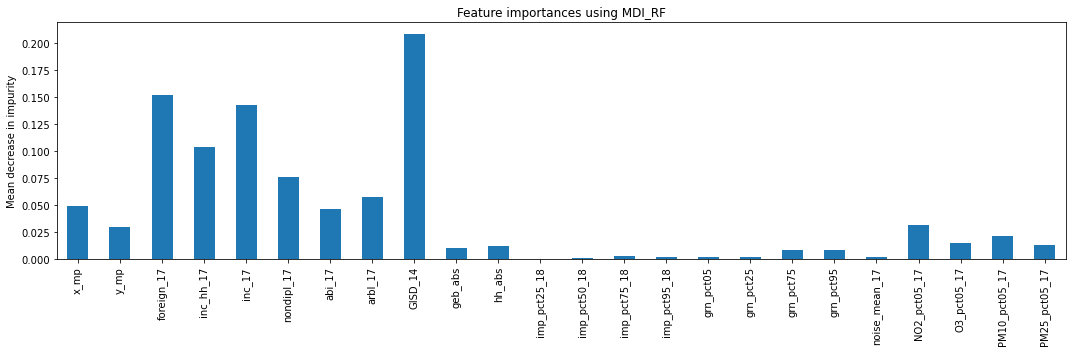

{'learning_rate': [0.1,
                   0.2,
                   0.3,
                   0.4,
                   0.5,
                   0.6,
                   0.7,
                   0.7999999999999999,
                   0.8999999999999999,
                   0.9999999999999999,
                   1.0999999999999999,
                   1.2,
                   1.3,
                   1.4,
                   1.5,
                   1.5999999999999999,
                   1.7,
                   1.8,
                   1.9,
                   2.0],
 'loss': ['linear', 'square', 'exponential'],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


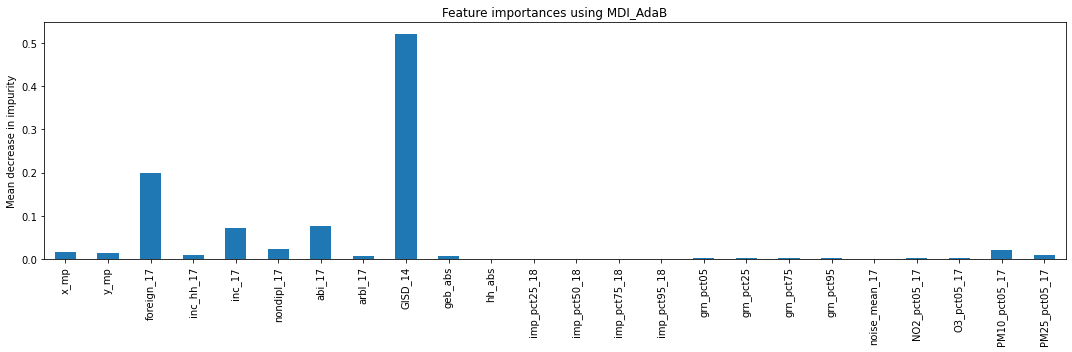

{'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'learning_rate': [0.01,
                   0.02,
                   0.03,
                   0.04,
                   0.05,
                   0.060000000000000005,
                   0.06999999999999999,
                   0.08,
                   0.09,
                   0.09999999999999999,
                   0.11,
                   0.12,
                   0.13,
                   0.14,
                   0.15000000000000002,
                   0.16,
                   0.17,
                   0.18000000000000002,
                   0.19,
                   0.2],
 'max_depth': [3, 5, 6, 10, 15, 20],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


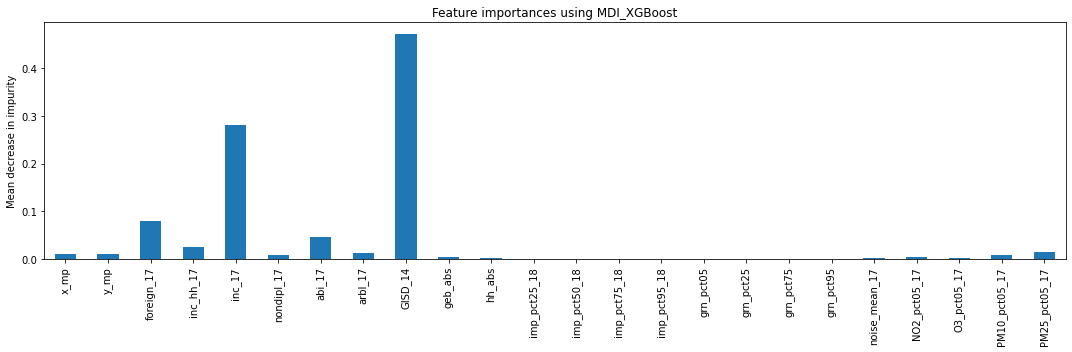

,x_mp,y_mp,foreign_17,inc_hh_17,inc_17,nondipl_17,abi_17,arbl_17,GISD_14,geb_abs,...,grn_pct05,grn_pct25,grn_pct75,grn_pct95,noise_mean_17,NO2_pct05_17,O3_pct05_17,PM10_pct05_17,PM25_pct05_17,Method
0,0.049270,0.026427,0.012187,0.049314,0.032806,0.036862,0.051116,0.052547,0.099851,0.043548,...,0.038932,0.042674,0.052472,0.023798,0.040718,0.057476,0.021970,0.059778,0.000000,LR
1,0.048159,0.027483,0.009080,0.044427,0.029033,0.037099,0.049544,0.056887,0.098347,0.043485,...,0.039100,0.044252,0.049943,0.026681,0.041131,0.058857,0.023338,0.061267,0.000000,LR_Ridge
2,0.048821,0.027251,0.010272,0.044391,0.031640,0.036907,0.050327,0.054413,0.099995,0.043310,...,0.039544,0.043403,0.048941,0.027526,0.041407,0.058446,0.022151,0.059907,0.000000,LR_Lasso
3,0.048579,0.027445,0.009550,0.043455,0.030819,0.036975,0.049970,0.055362,0.099747,0.043455,...,0.039573,0.043707,0.048401,0.028123,0.041514,0.058730,0.022461,0.060238,0.000000,LR_Elastic
4,0.049309,0.030085,0.152074,0.104072,0.142619,0.075989,0.046505,0.057432,0.208598,0.010592,...,0.001737,0.001989,0.008273,0.008961,0.001860,0.031638,0.015369,0.021920,0.012956,RF
5,0.017833,0.015532,0.198806,0.009285,0.072042,0.024889,0.076241,0.006788,0.520870,0.007825,...,0.001996,0.002667,0.003670,0.002289,0.001140,0.002618,0.002846,0.021139,0.009019,AdaB
6,0.010417,0.012030,0.079543,0.024850,0.281885,0.008079,0.046547,0.013271,0.471959,0.005416,...,0.000647,0.000941,0.000954,0.001227,0.002099,0.005477,0.003187,0.009442,0.016057,XGBoost


In [35]:
# Build models from scratch and find the feature importances

feature_imp = pd.DataFrame(columns = features)
# feature_imp['Method'] = None
# 'LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM','RF','AdaB', 'XGBoost'

methods = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'RF','AdaB', 'XGBoost']
for i in methods:
    toAppend_imp = Impurity_feature_importance(i, X_train, y_train, output_path)
    feature_imp = feature_imp.append(pd.DataFrame(toAppend_imp.reshape(1,-1), columns= features), ignore_index=True)

feature_imp['Method'] = methods
feature_imp

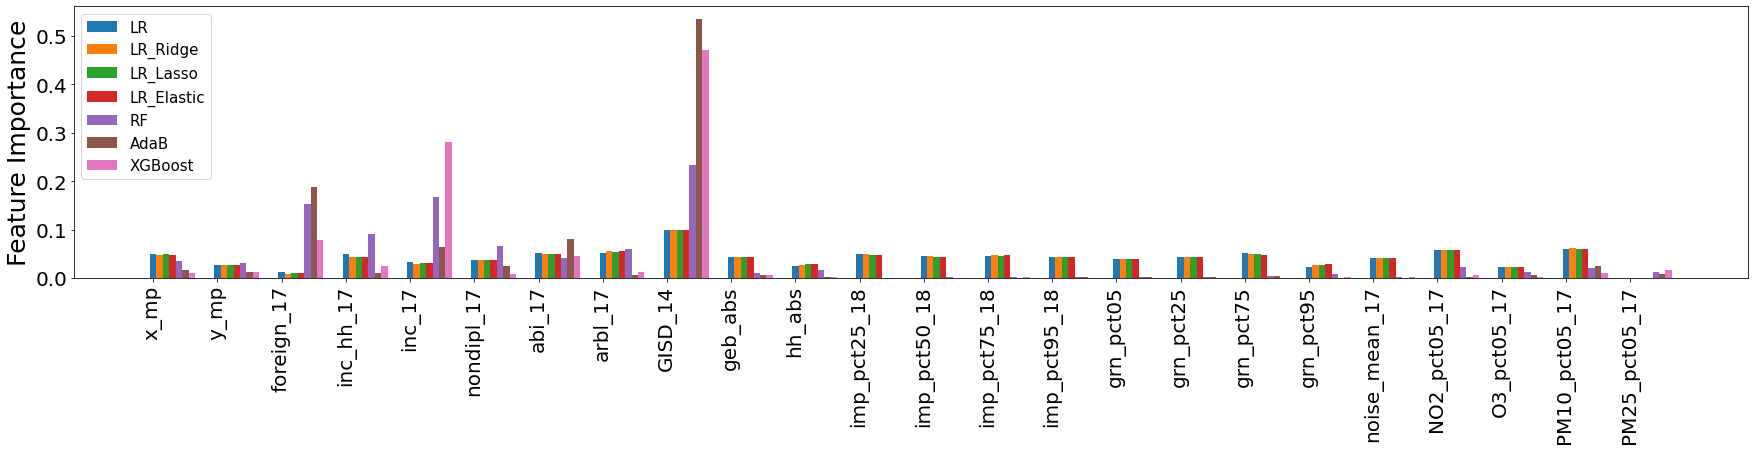

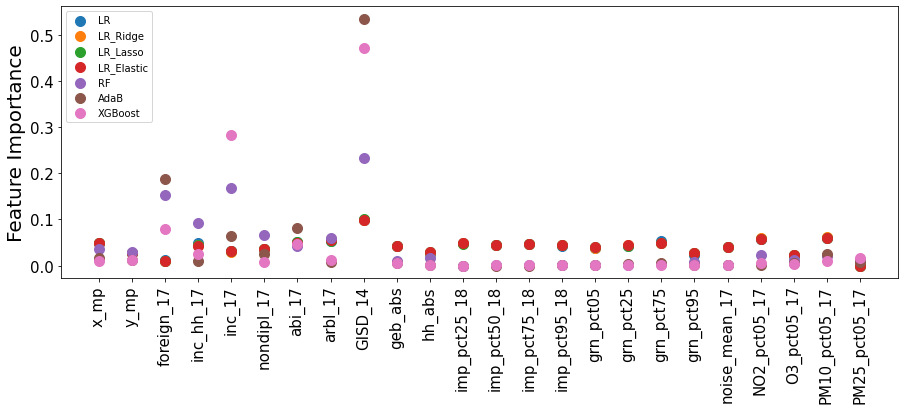

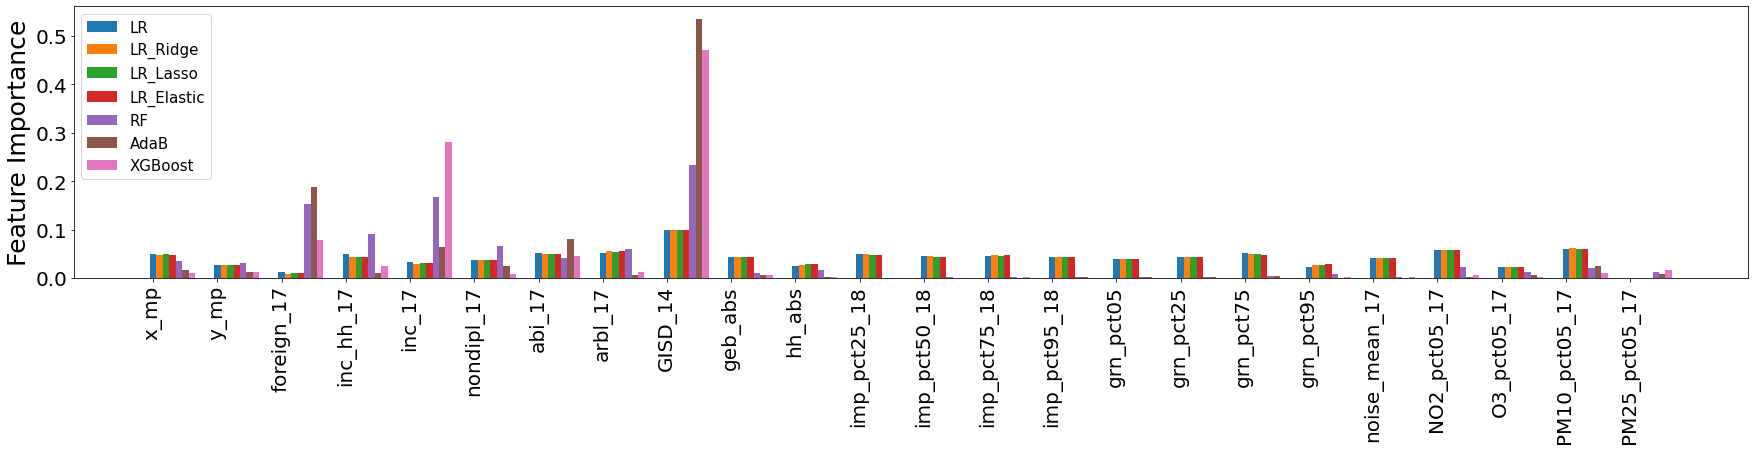

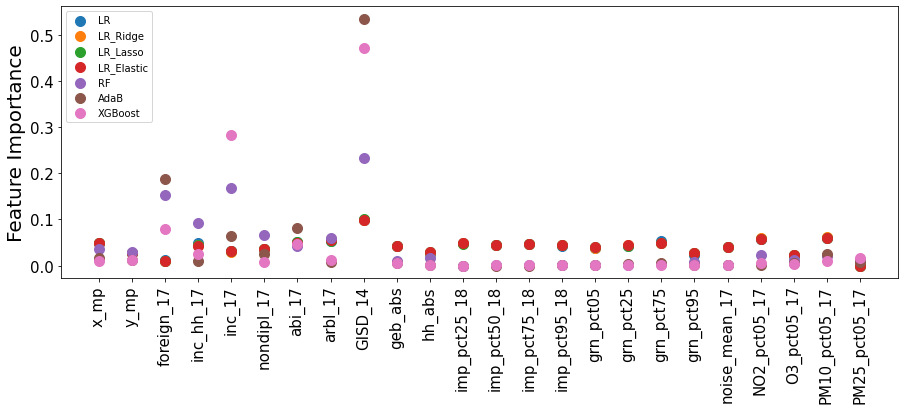

In [51]:
to_plot = feature_imp.drop(['Method'], axis = 1)
test_df = to_plot

for i in range(len(to_plot.columns)):
    if all(to_plot.iloc[:,i] < 0.01):
        test_df = test_df.drop(to_plot.columns[i], axis = 1)

feature_imp_plot_bar(test_df, methods, 20, output_path + 'Plots/Feature_importance_bar_001')
# feature_imp_plot_scatter(test_df, methods, 15, output_path + 'Plots/Feature_importance_scatter_001')

feature_imp_plot_bar(to_plot, methods, 20, output_path + 'Plots/Feature_importance_bar_all')
# feature_imp_plot_scatter(to_plot, methods, 15, output_path + 'Plots/Feature_importance_scatter_all' )


# Permutaion Feature Importance

In [59]:
def Permutation_feature_importance_from_model(model, method, X, y, file_path):
    ''' This function finds the corresponding feature importance for a trained model employing
        permutation feature importance
        
        Input:
        --------------------------
        
        model (e.g. SKlearn models): a trained model
        
        method (str): name of the method
        
        X (pandas dataframe): data for the predictors to which you try to find importance of features when performing prediction
        
        y (pandas dataframe, pandas serie): output to which you try to find importance of features when 
        performing prediction
        
        file_path (str): the path for saving results
        
        Output:
        ---------------------------
        variable_importances (pandas series): feature importance for all variables
    '''
        
        
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=2)

    variable_importances = pd.Series(result.importances_mean, index=X.columns)
    plot_feature_importances(variable_importances, method, file_path, 'Permutation')

    plt.show()
    return variable_importances

In [60]:
def Permutation_feature_importance(method, X_train, y_train , X, y, file_path):
    
    ''' This function, first, builds and trains a specific model, then, finds the corresponding feature importance for
        employing permutation feature importance
        
        Input:
        --------------------------

        method (str): name of the method
        
        X (pandas dataframe): data for the predictors to which you try to find importance of features when performing prediction
        
        y (pandas dataframe, pandas serie): output to which you try to find importance of features when 
        performing prediction
        
        file_path (str): the path for saving results
        
        Output:
        ---------------------------
        variable_importances (pandas series): feature importance for all variables
    '''
    
    # Build and fit the model with the proper data
    model = Build_fit_model(method, X_train, y_train)
    
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=2)

    variable_importances = pd.Series(result.importances_mean, index=X_train.columns)
    plot_feature_importances(variable_importances, method, file_path, 'Permutation')

    plt.show()
    return variable_importances

In [90]:
def Plot_permutation_feature_importance(feature_imp, thr, output_path, file_name):
    methods = feature_imp['Method']
    to_plot = feature_imp.drop(['Method'], axis = 1)
    temp_df = to_plot

    for i in range(len(to_plot.columns)):
        if all(to_plot.iloc[:,i] < thr):
            temp_df = temp_df.drop(to_plot.columns[i], axis = 1)

    feature_imp_plot_bar(temp_df, methods, 20, output_path + 'Plots/Feature_importance_per_bar_'+ str(thr).replace('.', '') 
                         + '_' + file_name)
    # feature_imp_plot_scatter(temp_df, methods, 10, output_path + 'Plots/Feature_importance_per_scatter_' + str(thr))

    feature_imp_plot_bar(to_plot, methods, 20, output_path + 'Plots/Feature_importance_per_bar_all_' + file_name)
    # feature_imp_plot_scatter(to_plot, methods, 10, output_path + 'Plots/Feature_importance_per_scatter_all' )

In [81]:
def Apply_permutation_feature_importance(methods, X, y, output_path, file_name, models = None):
    
    if models:
        feature_imp = pd.DataFrame(columns = features)
        for i in range(len(methods)):
            toAppend_imp = Permutation_feature_importance_from_model(models[i], methods[i], X_train, y_train, output_path 
                                                                     + methods[i] + '/' + methods[i] 
                                                                     + '_permutation_feature_importance_' + file_name)
            feature_imp = feature_imp.append(toAppend_imp, ignore_index=True)

        feature_imp['Method'] = methods
        feature_imp.to_csv(output_path + 'permutation_feature_importance_' + file_name + '.csv', sep=',', index=False)

    else:
        feature_imp = pd.DataFrame(columns = features)
        for i in methods:
            toAppend_imp = permutation_feature_importance(i, X_train, y_train, X_test, y_test, output_path 
                                                                     + methods[i] + '/' + methods[i] 
                                                                     + '_permutation_feature_importance_' + file_name)
            feature_imp = feature_imp.append(toAppend_imp, ignore_index=True)
            feature_imp = feature_imp.append(toAppend_imp, ignore_index=True)

        feature_imp['Method'] = methods
        feature_imp.to_csv(output_path + 'permutation_feature_importance_' + file_name + '.csv', sep=',', index=False)
        
    return feature_imp

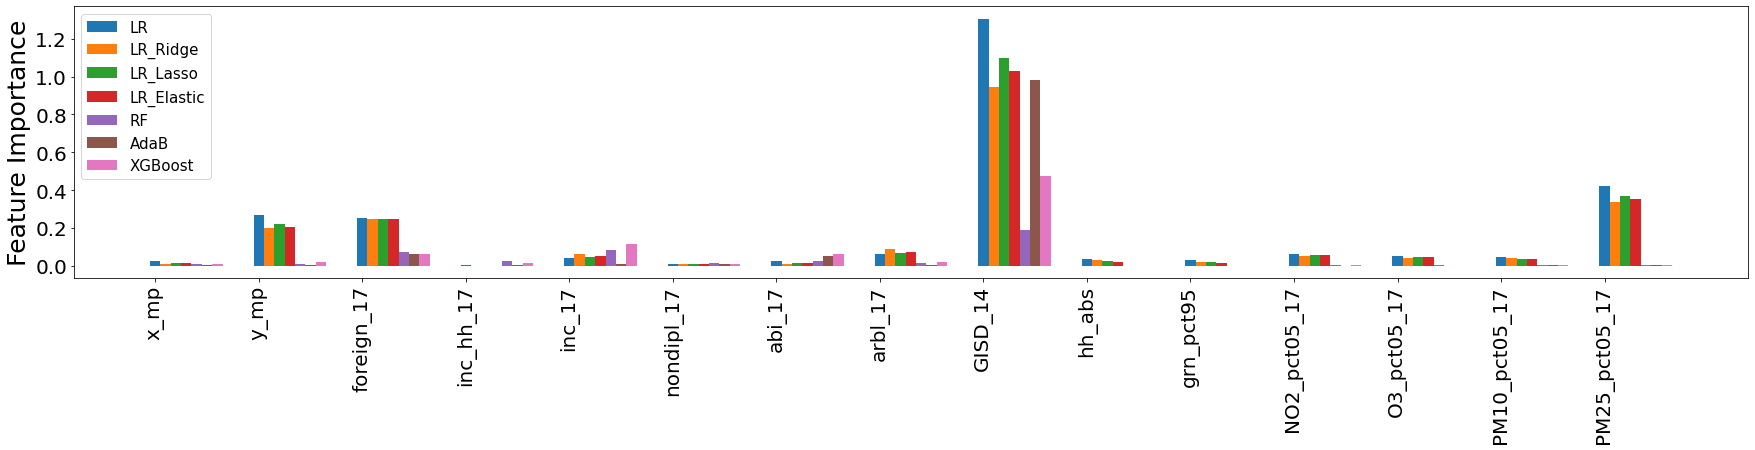

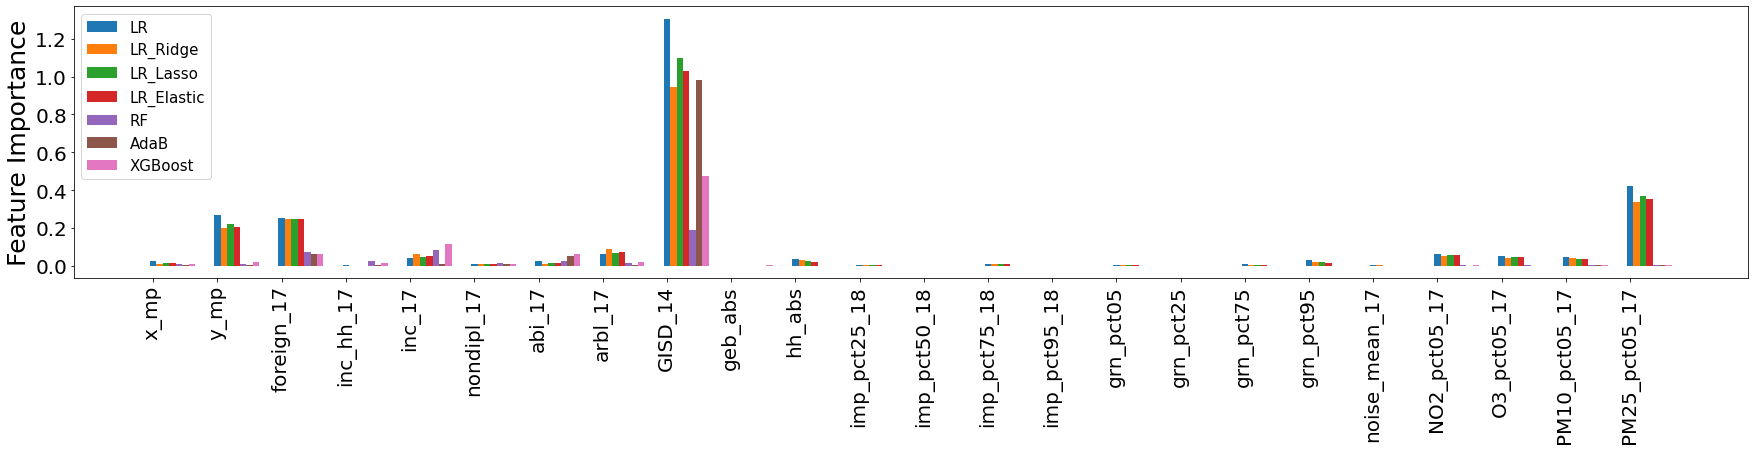

In [91]:
Plot_permutation_feature_importance(feature_imp, 0.01, output_path, 'Training')

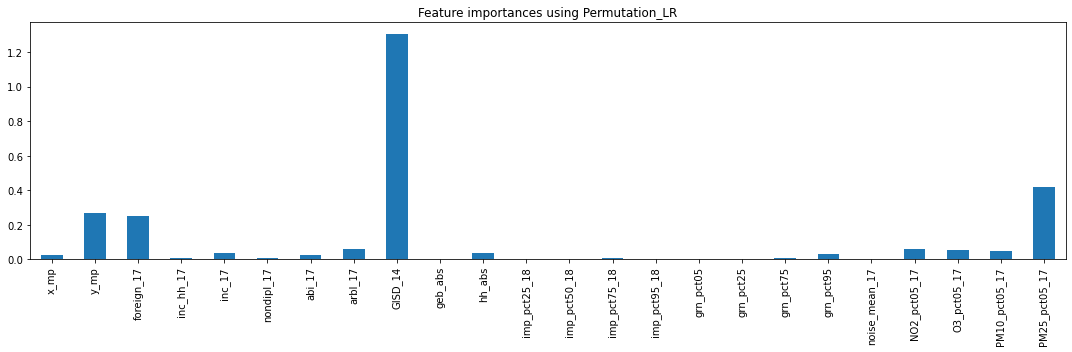

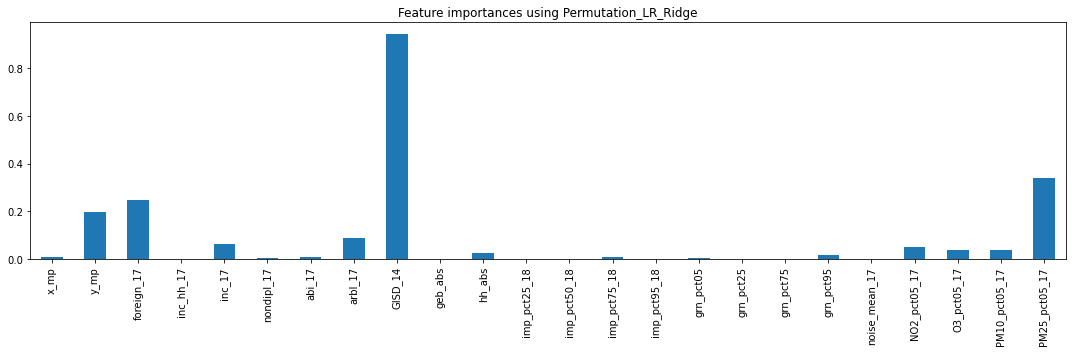

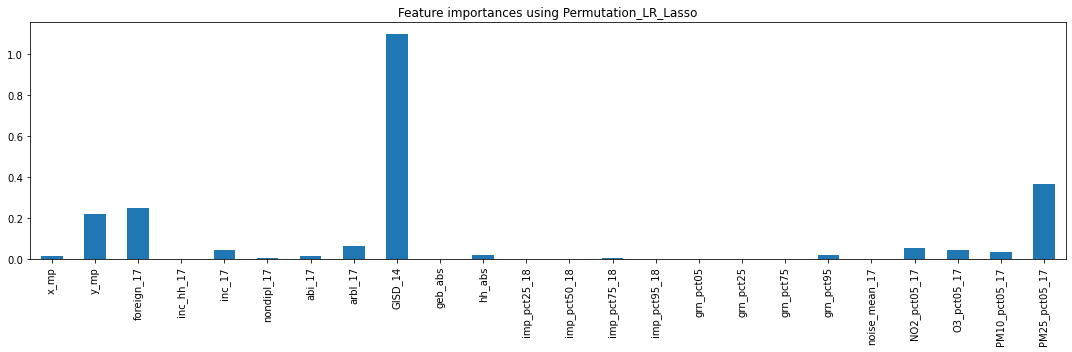

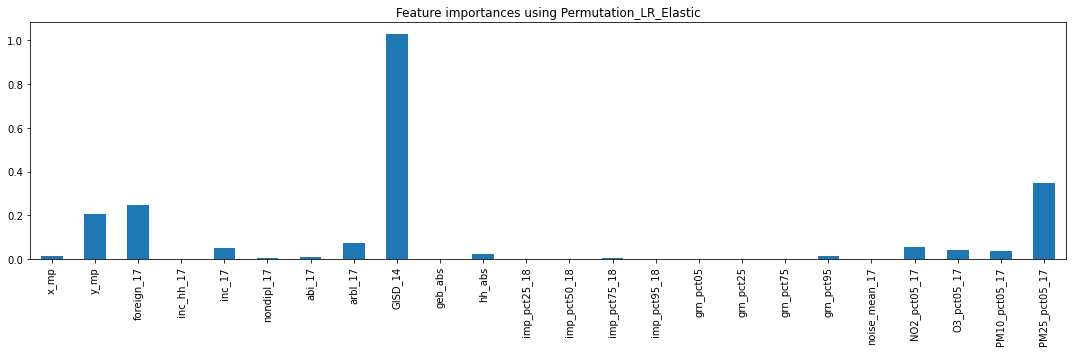

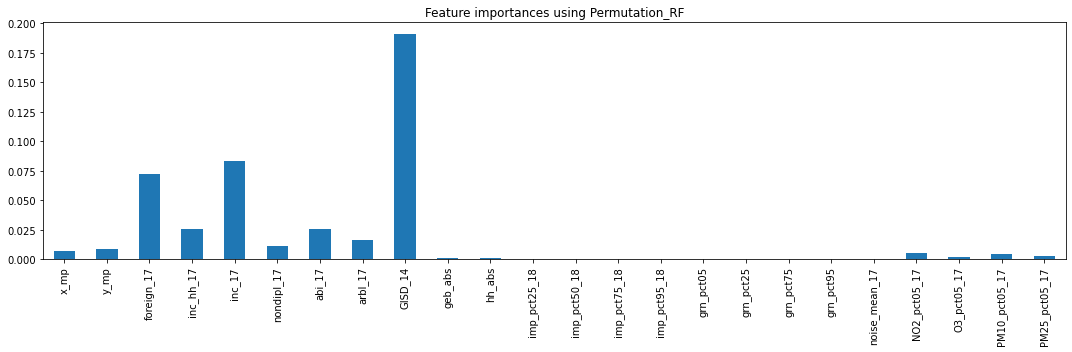

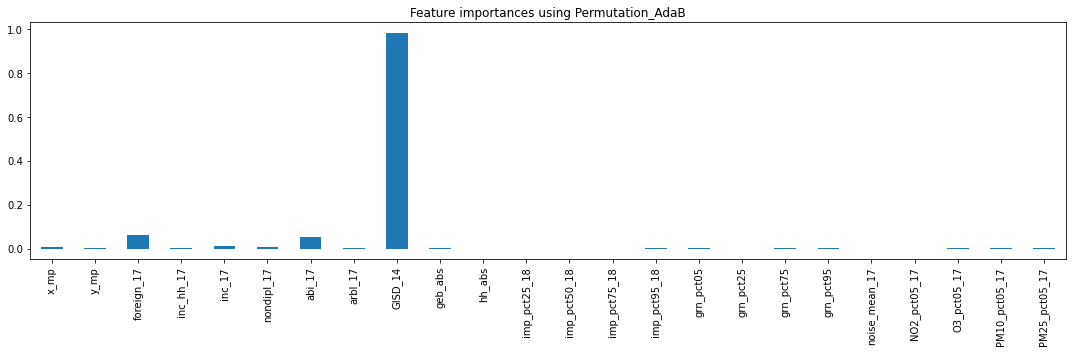

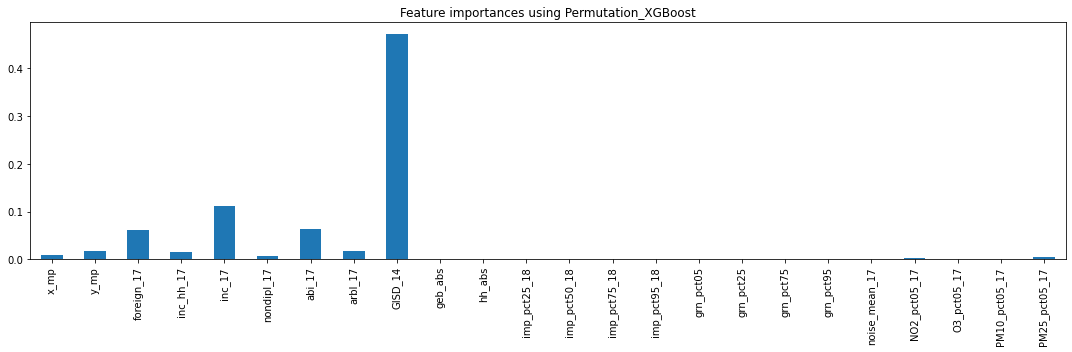

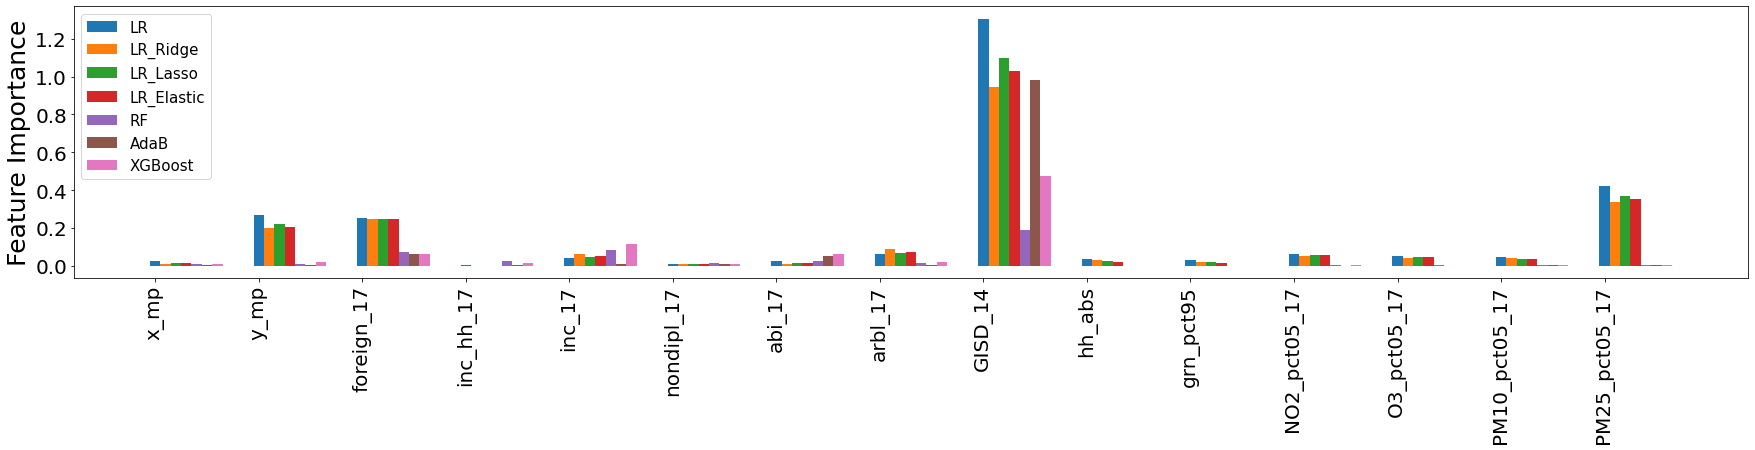

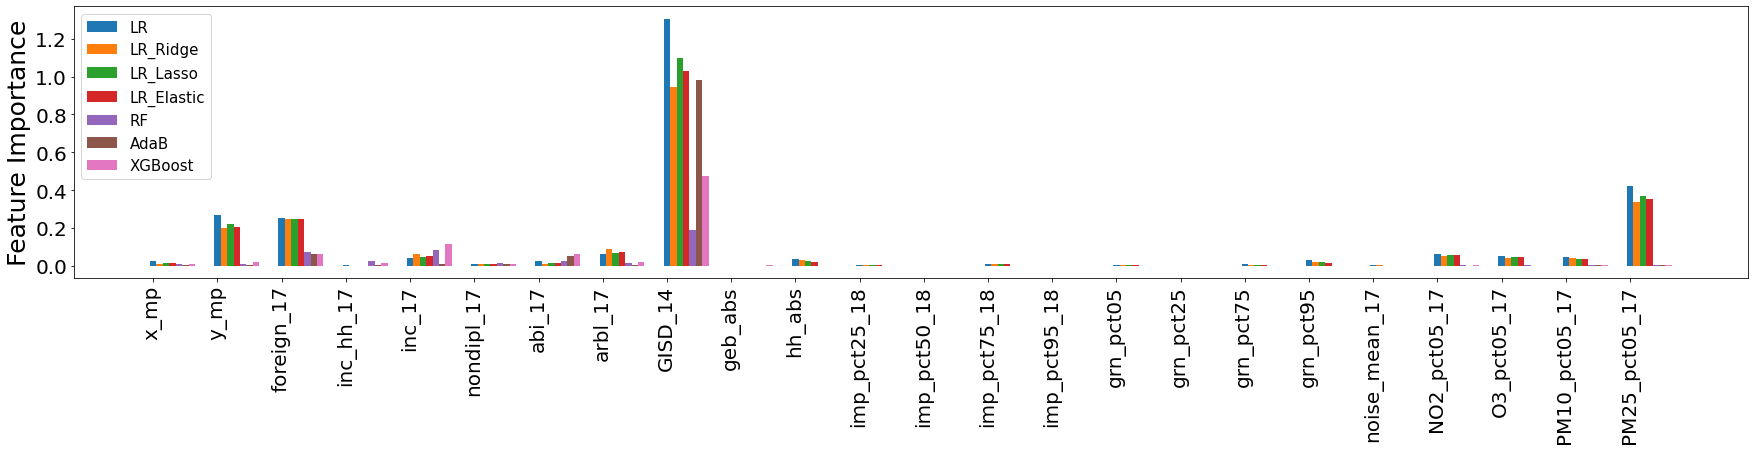

In [92]:
# Permutation feature importance for training data using already built models
feature_imp = Apply_permutation_feature_importance(methods, X_train, y_train, output_path, 'Training', models)
Plot_permutation_feature_importance(feature_imp, 0.01, output_path, 'Training')

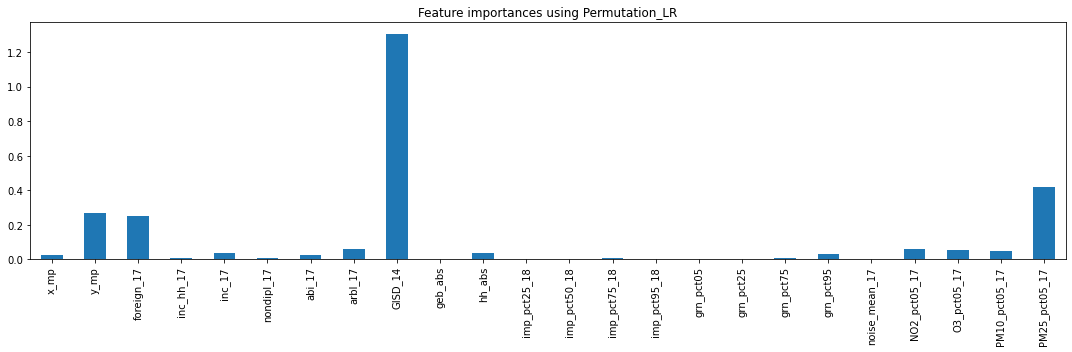

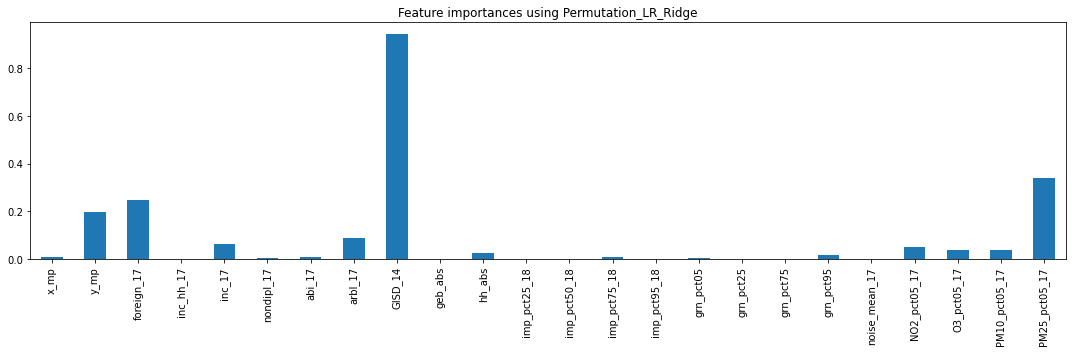

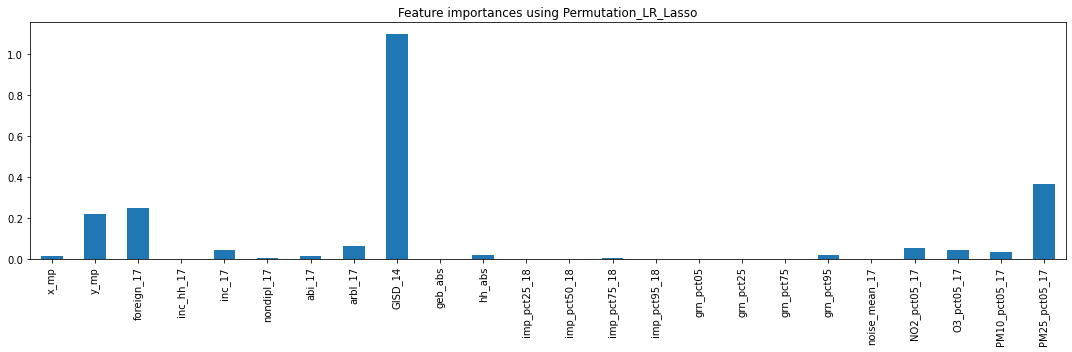

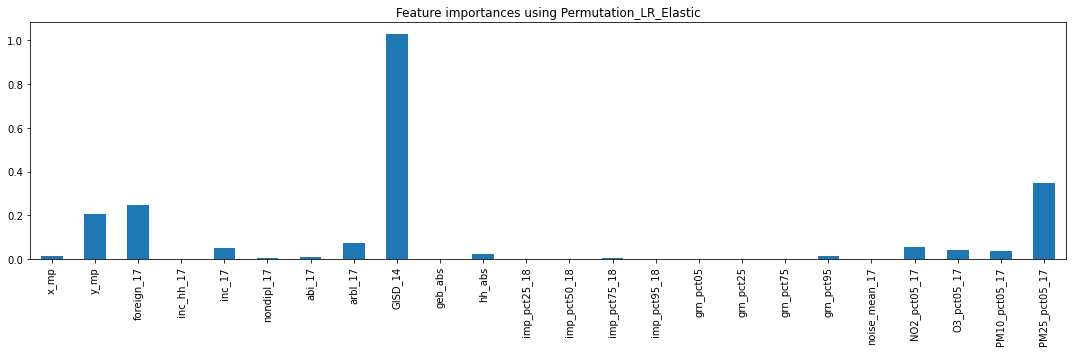

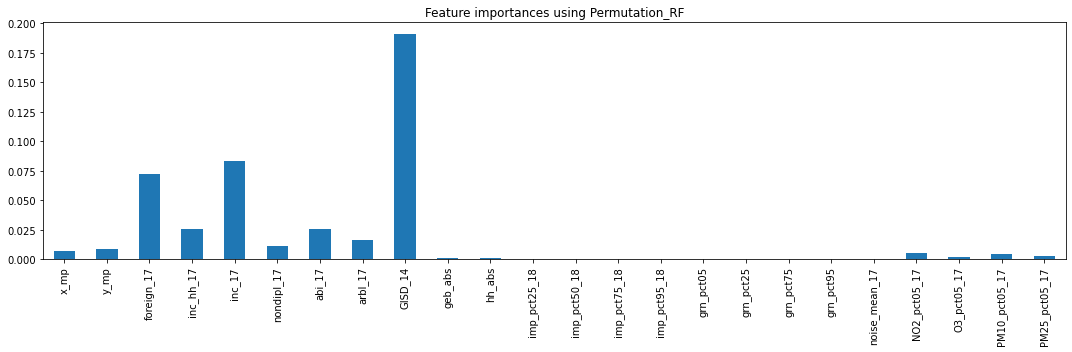

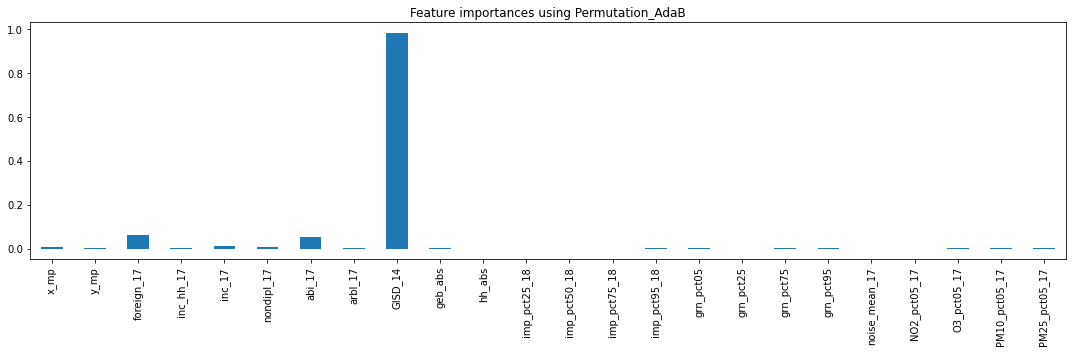

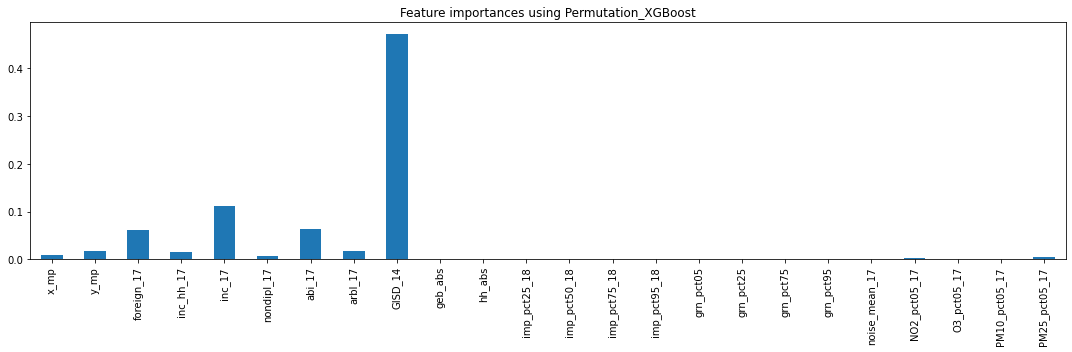

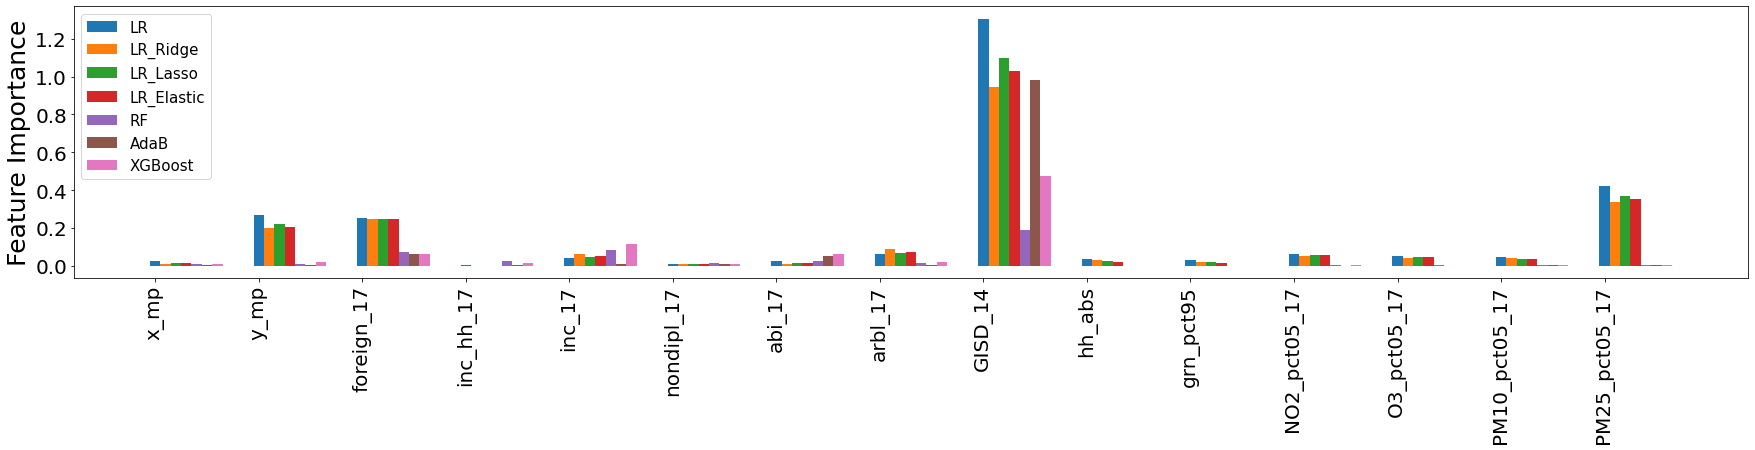

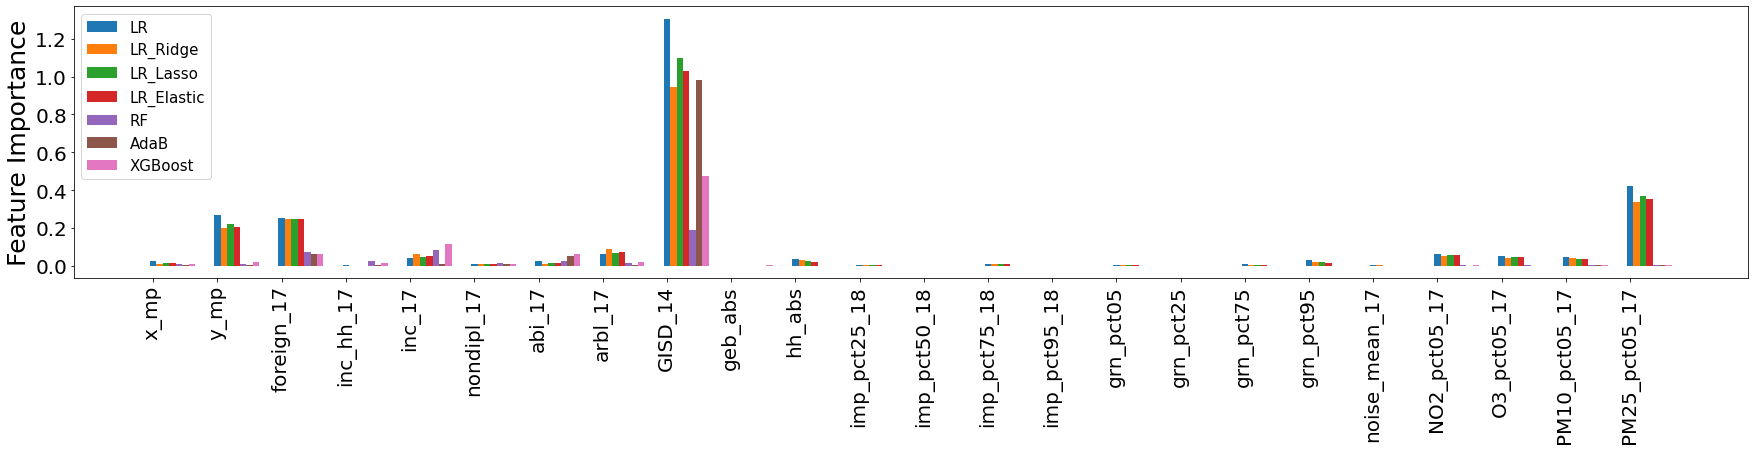

In [93]:
# Permutation feature importance for validation data using already built models

feature_imp = Apply_permutation_feature_importance(methods, X_test, y_test, output_path, 'Validation', models)
Plot_permutation_feature_importance(feature_imp, 0.01, output_path, 'Validation')

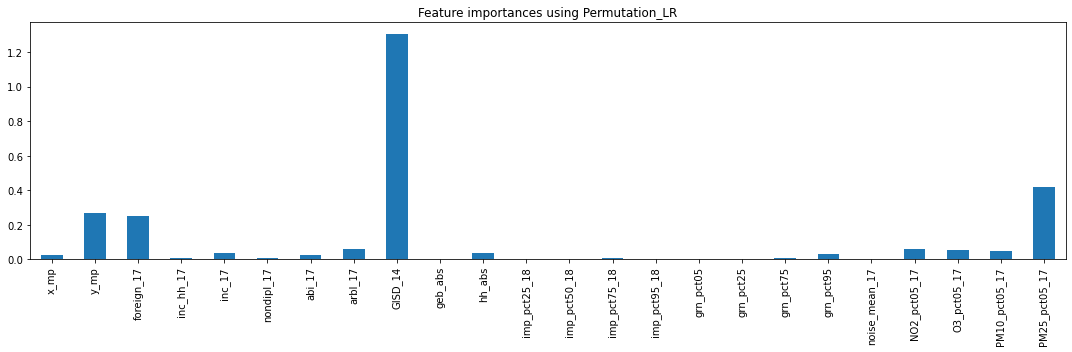

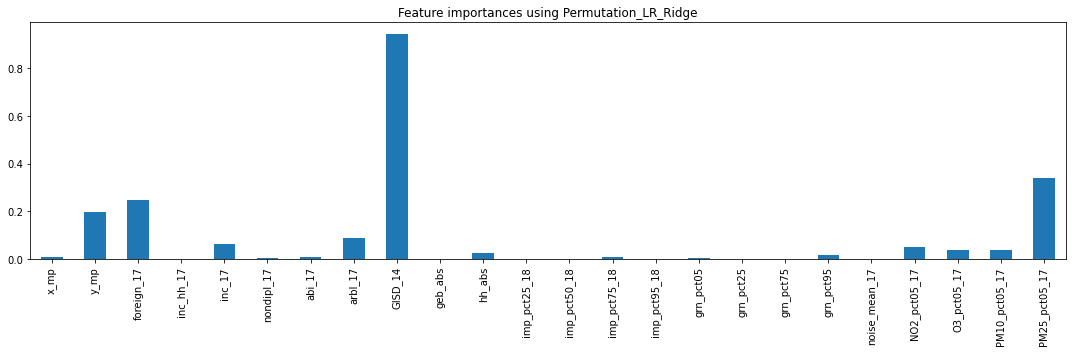

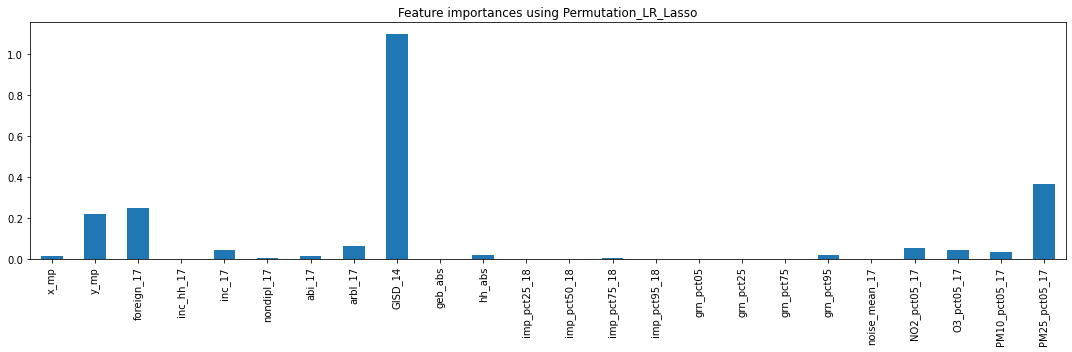

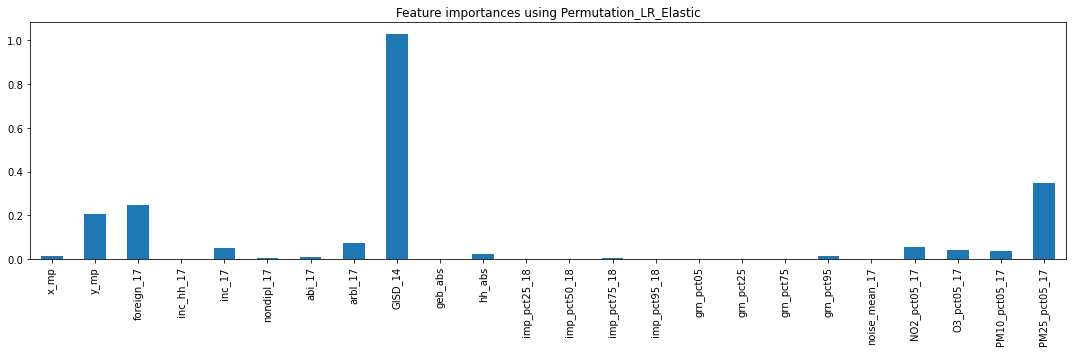

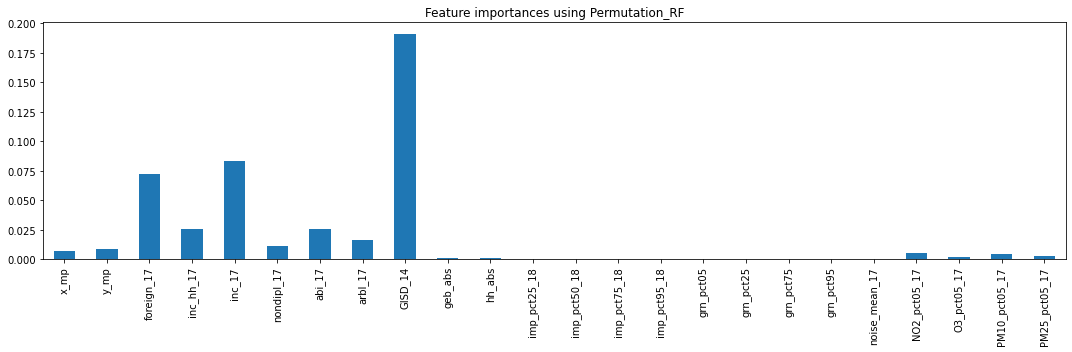

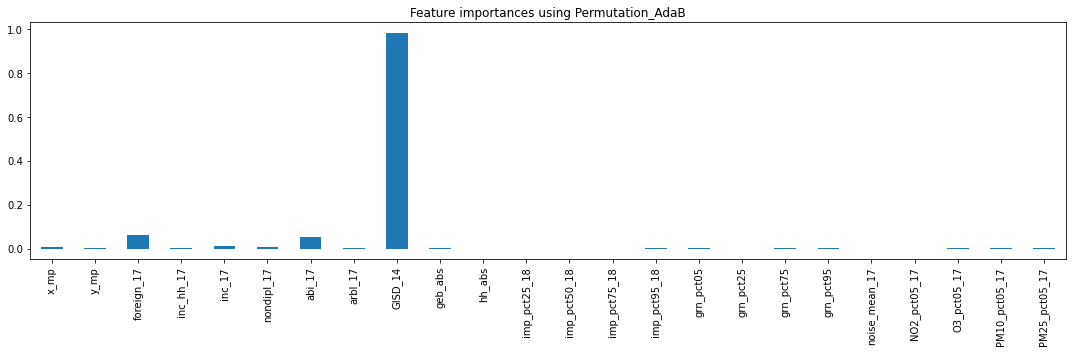

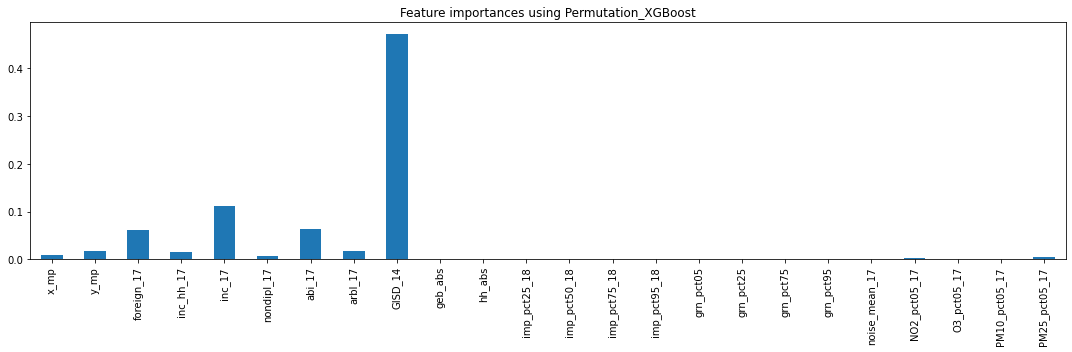

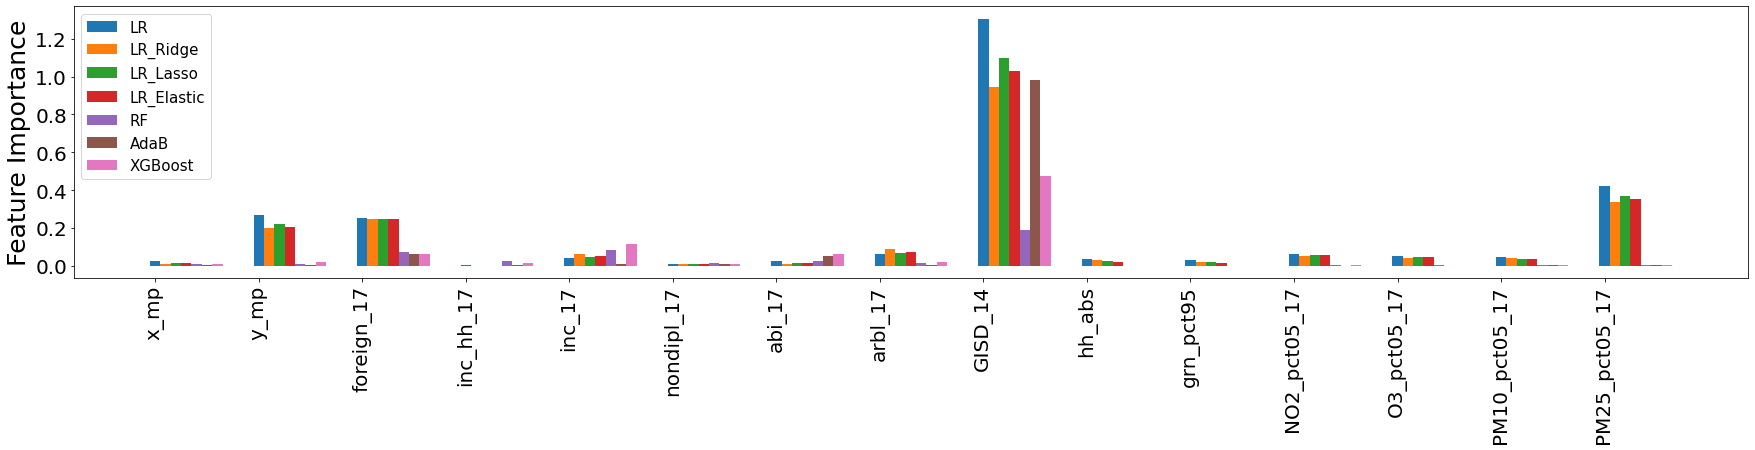

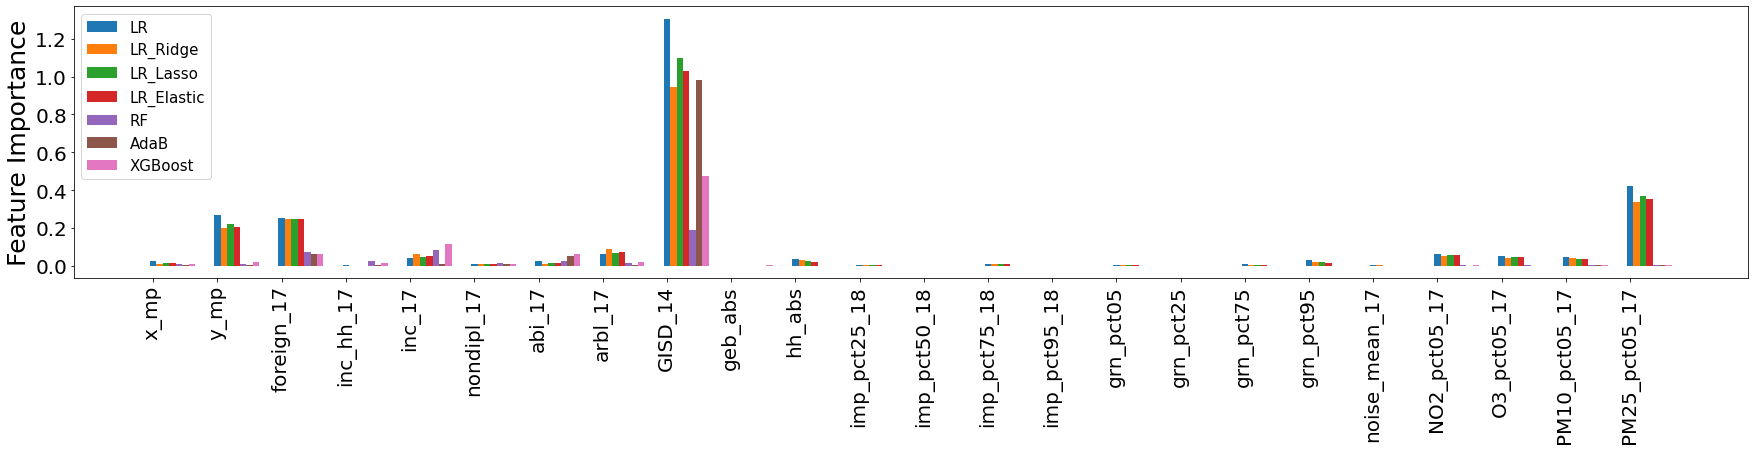

In [97]:
# Permutation feature importance for test data using already built models

feature_imp = Apply_permutation_feature_importance(methods, pred_X, pred_y, output_path, 'Test', models)
Plot_permutation_feature_importance(feature_imp, 0.01, output_path, 'Test')

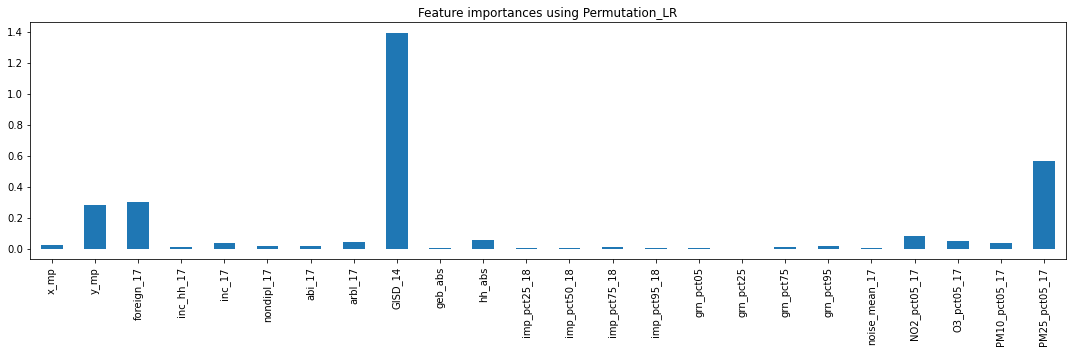

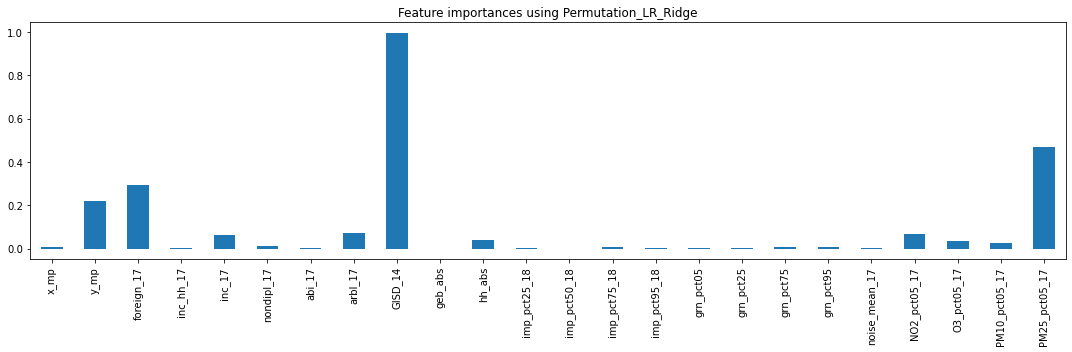

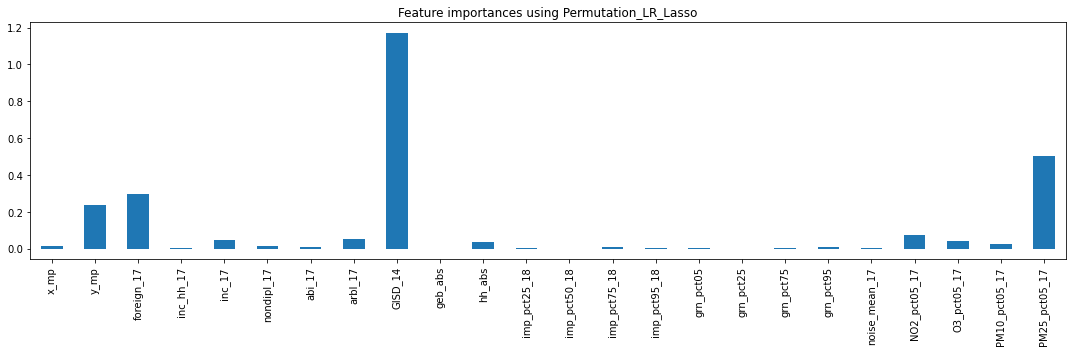

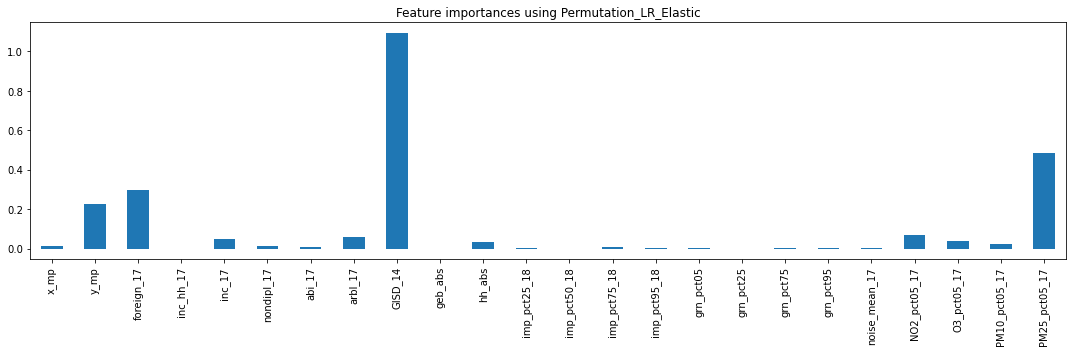

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


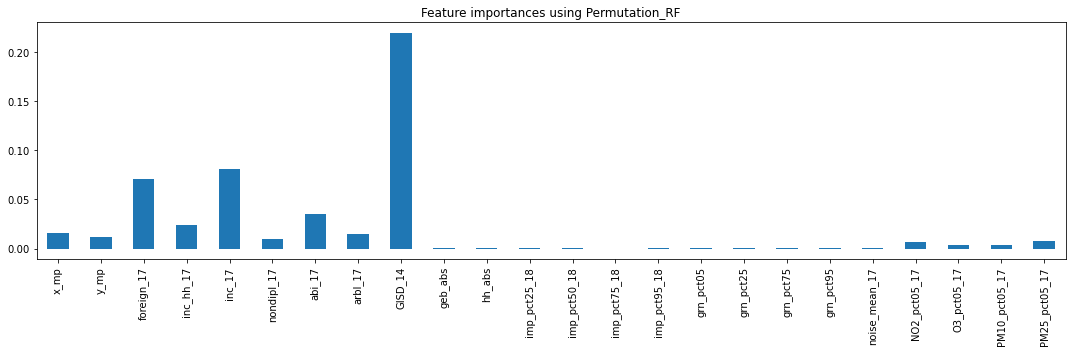

{'learning_rate': [0.1,
                   0.2,
                   0.3,
                   0.4,
                   0.5,
                   0.6,
                   0.7,
                   0.7999999999999999,
                   0.8999999999999999,
                   0.9999999999999999,
                   1.0999999999999999,
                   1.2,
                   1.3,
                   1.4,
                   1.5,
                   1.5999999999999999,
                   1.7,
                   1.8,
                   1.9,
                   2.0],
 'loss': ['linear', 'square', 'exponential'],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


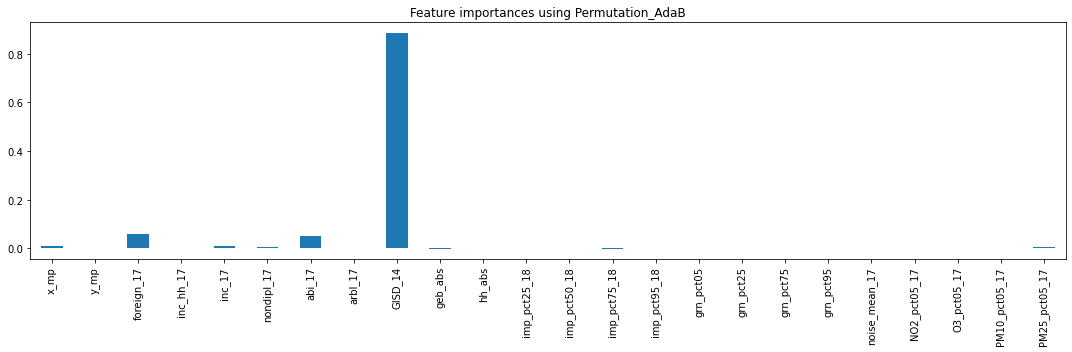

{'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'learning_rate': [0.01,
                   0.02,
                   0.03,
                   0.04,
                   0.05,
                   0.060000000000000005,
                   0.06999999999999999,
                   0.08,
                   0.09,
                   0.09999999999999999,
                   0.11,
                   0.12,
                   0.13,
                   0.14,
                   0.15000000000000002,
                   0.16,
                   0.17,
                   0.18000000000000002,
                   0.19,
                   0.2],
 'max_depth': [3, 5, 6, 10, 15, 20],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


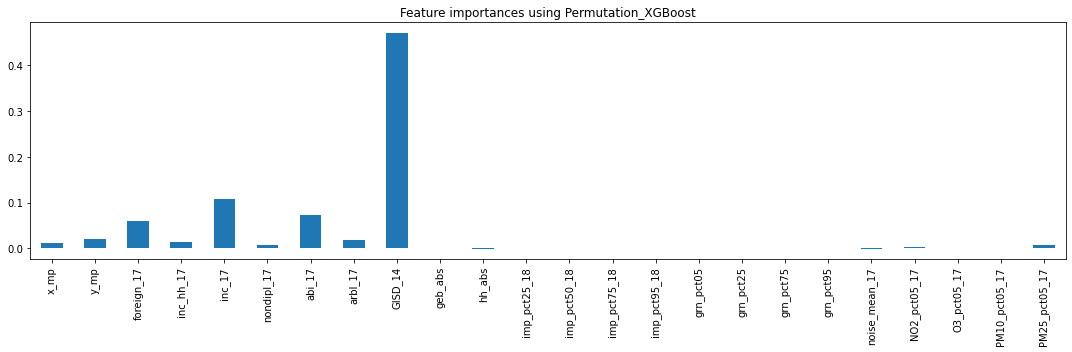

,x_mp,y_mp,foreign_17,inc_hh_17,inc_17,nondipl_17,abi_17,arbl_17,GISD_14,geb_abs,...,grn_pct05,grn_pct25,grn_pct75,grn_pct95,noise_mean_17,NO2_pct05_17,O3_pct05_17,PM10_pct05_17,PM25_pct05_17,Method
0,0.024147,0.284130,0.299485,0.009874,0.036051,0.014109,0.014937,0.044435,1.390115,0.000176,...,0.001930,-0.000034,0.011664,0.014398,0.000843,0.080988,0.047443,0.033979,0.565743,LR
1,0.007471,0.218296,0.294897,0.000596,0.063642,0.012934,0.003632,0.070257,0.995195,0.000003,...,0.001957,0.000280,0.005646,0.005835,0.000933,0.068047,0.032561,0.027300,0.467291,LR_Ridge
2,0.013417,0.236850,0.298848,0.000775,0.043635,0.013924,0.007306,0.050676,1.169941,0.000000,...,0.001526,0.000030,0.004932,0.005552,0.000629,0.072470,0.040234,0.026035,0.502603,LR_Lasso
3,0.010342,0.224472,0.297996,0.000000,0.049162,0.013573,0.005256,0.056180,1.092017,0.000000,...,0.001537,0.000084,0.004046,0.004285,0.000623,0.069774,0.037030,0.024908,0.482031,LR_Elastic
4,0.015323,0.011435,0.070839,0.023720,0.080542,0.009771,0.035219,0.014815,0.219152,0.001009,...,0.000130,0.000375,0.000988,0.000903,0.000453,0.006794,0.003709,0.003356,0.007657,RF
5,0.008502,0.003184,0.060839,0.001106,0.009946,0.005143,0.050346,0.002386,0.884730,-0.000210,...,0.000117,0.000396,0.001092,0.000077,0.000158,0.000006,0.000096,0.000677,0.006986,AdaB
6,0.011005,0.019649,0.060721,0.014113,0.108675,0.006981,0.071873,0.018311,0.469749,0.000424,...,-0.000102,-0.000082,-0.000031,-0.000076,-0.000331,0.002877,0.001010,0.001534,0.007237,XGBoost


In [41]:
# Build models from scratch and find the feature importances

feature_imp = pd.DataFrame(columns = features)
# feature_imp['Method'] = None
# 'LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'AdaB', 'XGBoost'

methods = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'RF', 'AdaB', 'XGBoost']
for i in methods:
    toAppend_imp = permutation_feature_importance(i, X_train, y_train, X_test, y_test, output_path + i + '/' + i + '_permutation_feature_importance' )
    feature_imp = feature_imp.append(toAppend_imp, ignore_index=True)

feature_imp['Method'] = methods
feature_imp

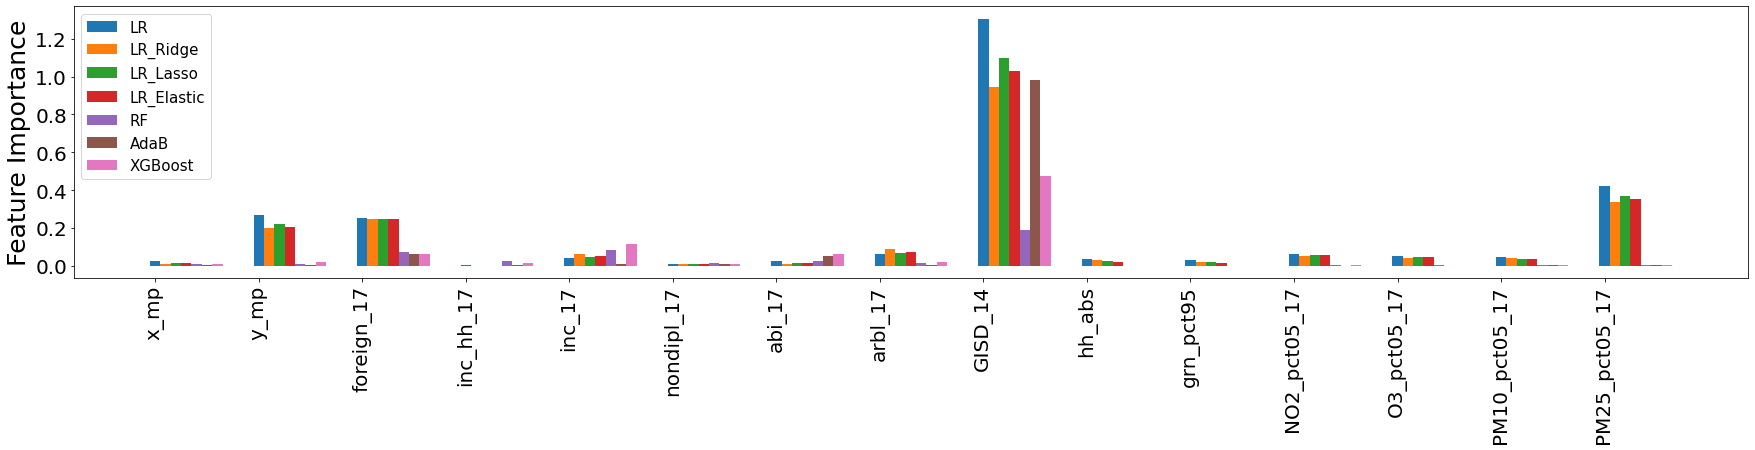

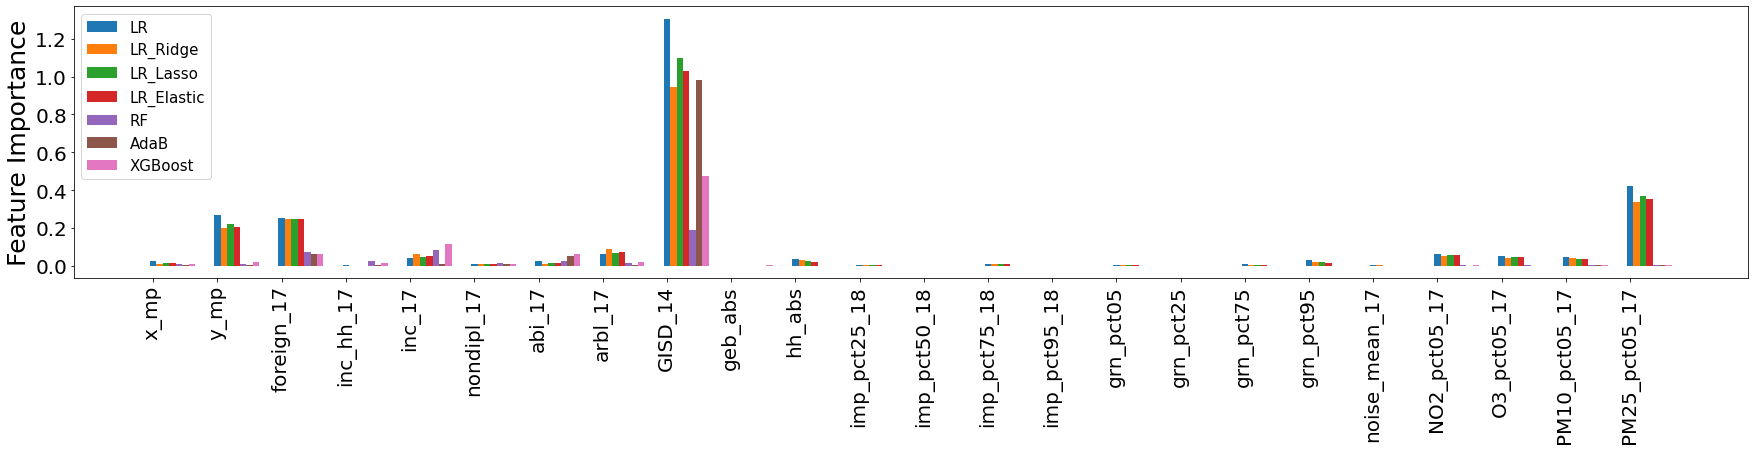

In [64]:
to_plot = feature_imp.drop(['Method'], axis = 1)
test_df = to_plot

for i in range(len(to_plot.columns)):
    if all(to_plot.iloc[:,i] < 0.01):
        test_df = test_df.drop(to_plot.columns[i], axis = 1)

feature_imp_plot_bar(test_df, methods, 20, output_path + 'Plots/Feature_importance_per_bar_001')
# feature_imp_plot_scatter(test_df, methods, 10, output_path + 'Plots/Feature_importance_per_scatter_001')

feature_imp_plot_bar(to_plot, methods, 20, output_path + 'Plots/Feature_importance_per_bar_all')
# feature_imp_plot_scatter(to_plot, methods, 10, output_path + 'Plots/Feature_importance_per_scatter_all' )

# SHAP

In [99]:
def Compute_shap_values(method, X_train, y_train , X, y, file_path, model = None):
    
    if not model:
        # Build and fit the model with the proper data
        model = Build_fit_model(method, X_train, y_train)
    
    if method == 'GAM':
        explainer = shap.explainers.Additive(model.predict, X)
    else:
        explainer = shap.Explainer(model)
        
    shap_values = explainer(X)
    
    return shap_values

In [19]:
def shap_summary_plot(method, shap_values, X, columns, file_path):
    plt.title(method)
    shap.summary_plot(shap_values, features = X_test, feature_names = columns)
    plt.savefig(file_path)
    plt.show()

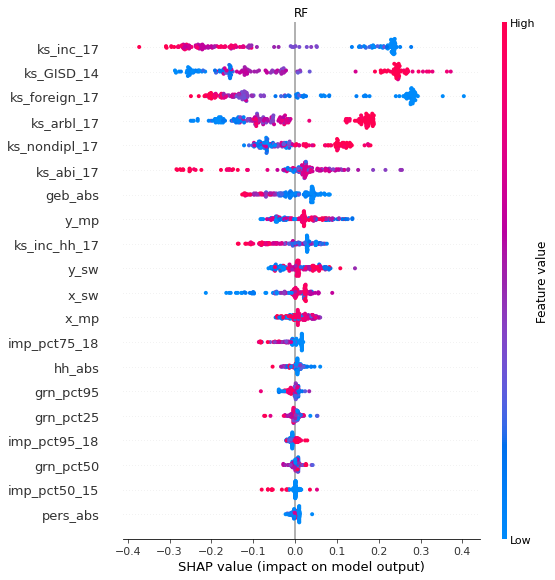

<Figure size 432x288 with 0 Axes>

In [18]:
method = 'RF'
RF_shap_values = shap_feature_importance(method, X_train, y_train, X_test, y_test, output_path + method + '/' + method + '_SHAP_feature_importance')
shap_summary_plot(method, RF_shap_values.values, X_test, X_test.columns, output_path + method + '/' + method + '_SHAP_feature_importance')

In [23]:
feature_imp = pd.DataFrame(columns = features)
# feature_imp['Method'] = None
# 'LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'AdaB', 'XGBoost'

methods = ['RF']
for i in methods:
    toAppend_imp = shap_feature_importance(i, X_train, y_train, X_test, y_test, output_path + i + '/' + i + '_permutation_feature_importance')
    feature_imp = feature_imp.append(pd.DataFrame(toAppend_imp.values, columns= features), ignore_index=True)

# feature_imp['Method'] = methods
feature_imp

,x_sw,y_sw,x_mp,y_mp,ks_foreign_17,ks_inc_hh_17,ks_inc_17,ks_nondipl_17,ks_abi_17,ks_arbl_17,...,imp_mean_18,imp_pct75_18,imp_pct95_18,grn_pct05,grn_pct25,grn_pct50,grn_mean,grn_pct75,grn_pct95,noise_mean_17
0,-0.002054,-0.009017,0.021573,0.045938,0.273305,0.027924,0.229480,0.106055,-0.023609,-0.025826,...,0.002725,0.016625,-0.008188,0.013743,-0.001357,-0.003194,0.008017,0.001663,0.007178,0.000717
1,-0.101565,-0.002318,-0.025773,-0.026252,-0.158043,-0.080272,-0.260200,-0.067371,-0.272522,-0.084758,...,0.005685,-0.025197,0.002837,0.007117,0.010206,0.000647,-0.003210,-0.001830,0.003102,-0.006737
2,0.022938,0.006639,0.006557,0.018136,0.282574,0.033191,0.234043,0.121673,0.017531,0.172157,...,0.006936,0.016007,-0.006440,0.000134,-0.003588,-0.002270,0.005437,-0.002902,0.005902,0.001177
3,-0.001655,0.031801,0.031435,0.087624,0.249460,-0.014787,0.211790,0.129249,0.216142,-0.033935,...,0.004839,0.016753,-0.018878,0.001147,-0.007847,0.007598,0.002530,0.000930,0.007608,0.025740
4,-0.099643,0.006759,-0.031052,-0.067018,-0.177240,-0.084192,-0.270777,-0.101809,-0.274844,-0.089572,...,0.000146,0.005973,0.008287,-0.003466,-0.017375,-0.017044,-0.000850,-0.005129,0.000861,0.009487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,0.024836,0.010372,-0.014458,0.017399,0.272524,0.032439,0.232686,0.133405,0.021698,0.184643,...,0.006541,0.016584,-0.006258,0.000635,-0.003803,-0.005998,0.002195,0.000694,0.001814,0.001295
168,-0.007775,0.072450,-0.012344,0.101353,-0.133067,0.066052,-0.146283,-0.050438,0.086574,-0.010755,...,-0.000662,0.004483,0.011042,0.002832,0.000971,0.010786,0.006869,0.012190,-0.011665,0.001689
169,0.041843,-0.041846,0.038833,-0.035164,-0.128548,-0.057822,-0.199967,-0.079076,0.065170,-0.196679,...,0.008781,0.002384,-0.009793,-0.009409,-0.008058,0.022078,0.004552,0.003085,-0.013582,0.001691
170,0.023488,0.043815,-0.001623,0.040046,0.258874,0.030332,0.222680,0.095759,0.017452,0.182376,...,0.003297,0.016389,-0.006580,-0.000554,-0.001275,0.003076,0.002377,0.001801,0.004585,0.001203
